In [1]:
import numpy as np
import pandas as pd
import math
import glob
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn import tree
import matplotlib.pyplot as plt
import lightgbm as lgbm

from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import  precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve,auc
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import cross_validate
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
import re

import optuna  # pip install optuna
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from optuna.integration import LightGBMPruningCallback


In [25]:
data = pd.read_csv(
  '../final/final_ft_application_train.csv'
).rename(
  columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)
)
data = data.loc[:,~data.columns.duplicated()]
predictor=[x for x in data.columns if x !='TARGET']
data_train, X_test1, data_test, y_test1 = train_test_split(data[predictor], data.TARGET, test_size=0.3, random_state=111)
data_train=data_train.dropna(axis=1,thresh=0.8*data_train.shape[0])
data_test=data_test[data_train.index]
data_test.reset_index()
data_train.reset_index()

,index,SK_ID_CURR,CNT_CHILDREN_mean,CNT_CHILDREN_median,AMT_INCOME_TOTAL_mean,AMT_INCOME_TOTAL_median,AMT_CREDIT_mean,AMT_CREDIT_median,AMT_ANNUITY_mean,AMT_ANNUITY_median,...,previous_application_ft_PRODUCT_COMBINATION_POSindustrywithoutinterest_median,previous_application_ft_PRODUCT_COMBINATION_POSindustrywithoutinterest_mean,previous_application_ft_PRODUCT_COMBINATION_POSmobilewithinterest_median,previous_application_ft_PRODUCT_COMBINATION_POSmobilewithinterest_mean,previous_application_ft_PRODUCT_COMBINATION_POSmobilewithoutinterest_median,previous_application_ft_PRODUCT_COMBINATION_POSmobilewithoutinterest_mean,previous_application_ft_PRODUCT_COMBINATION_POSotherwithinterest_median,previous_application_ft_PRODUCT_COMBINATION_POSotherwithinterest_mean,previous_application_ft_PRODUCT_COMBINATION_POSotherswithoutinterest_median,previous_application_ft_PRODUCT_COMBINATION_POSotherswithoutinterest_mean
0,172241,299604,0.099950,0.099950,0.001127,0.001127,0.057747,0.057747,0.083364,0.083364,...,0.0,0.0,0.00000,0.247525,0.0,0.247525,0.0,0.0,0.0,0.0
1,144232,267231,0.000000,0.000000,0.001704,0.001704,0.325843,0.325843,0.261602,0.261602,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,89075,203425,0.000000,0.000000,0.001012,0.001012,0.438202,0.438202,0.258533,0.258533,...,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,250906,390318,0.049975,0.049975,0.002858,0.002858,0.323317,0.323317,0.152340,0.152340,...,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
4,229122,365381,0.049975,0.049975,0.000858,0.000858,0.213483,0.213483,0.101990,0.101990,...,0.0,0.0,0.49505,0.495050,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215252,105747,222703,0.000000,0.000000,0.000858,0.000858,0.056180,0.056180,0.053925,0.053925,...,0.0,0.0,0.49505,0.495050,0.0,0.000000,0.0,0.0,0.0,0.0
215253,102486,218974,0.000000,0.000000,0.000858,0.000858,0.054721,0.054721,0.080887,0.080887,...,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
215254,135892,257621,0.000000,0.000000,0.000704,0.000704,0.090517,0.090517,0.115436,0.115436,...,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
215255,10196,111871,0.000000,0.000000,0.001396,0.001396,0.257978,0.257978,0.135301,0.135301,...,0.0,0.0,0.49505,0.495050,0.0,0.000000,0.0,0.0,0.0,0.0


In [27]:
def objective(trial, X, y):
    # 参数网格
    param_grid = {
        "objective": "binary",
        "is_unbalance": True,
        "metric": "auc",
        "verbosity": -1,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-4, 1),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "cat_smooth": trial.suggest_int("cat_smooth", 0, 100),
        "random_state": 2021,
    }
    # 5折交叉验证
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)
    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        

        # LGBM建模
        model = lgbm.LGBMClassifier(**param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="roc_auc",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "auc")
            ],
        )
        # 模型预测
        preds = model.predict_proba(X_test)[:,1]
        # 优化指标logloss最小
        cv_scores[idx] = metrics.roc_auc_score(y_test, preds)

    return np.mean(cv_scores)

In [29]:
study = optuna.create_study(direction="maximize", study_name="LGBM Classifier")
func = lambda trial: objective(trial,data_train,data_test)
study.optimize(func, n_trials=10, show_progress_bar=True)
model = lgbm.LGBMClassifier(**study.best_trial.params)
model = model.fit(data_train,data_test)

[I 2021-10-19 23:03:57,526] A new study created in memory with name: LGBM Classifier
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


[1]	valid_0's auc: 0.694737
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.706796
[3]	valid_0's auc: 0.712423
[4]	valid_0's auc: 0.71623
[5]	valid_0's auc: 0.722133
[6]	valid_0's auc: 0.725371
[7]	valid_0's auc: 0.726452
[8]	valid_0's auc: 0.728419
[9]	valid_0's auc: 0.730559
[10]	valid_0's auc: 0.731863
[11]	valid_0's auc: 0.732806
[12]	valid_0's auc: 0.733473
[13]	valid_0's auc: 0.735035
[14]	valid_0's auc: 0.736074
[15]	valid_0's auc: 0.736691
[16]	valid_0's auc: 0.737308
[17]	valid_0's auc: 0.73798
[18]	valid_0's auc: 0.738219
[19]	valid_0's auc: 0.738477
[20]	valid_0's auc: 0.738943
[21]	valid_0's auc: 0.739443
[22]	valid_0's auc: 0.739882
[23]	valid_0's auc: 0.740043
[24]	valid_0's auc: 0.739887
[25]	valid_0's auc: 0.740218
[26]	valid_0's auc: 0.740686
[27]	valid_0's auc: 0.741035
[28]	valid_0's auc: 0.741775
[29]	valid_0's auc: 0.742002
[30]	valid_0's auc: 0.741916
[31]	valid_0's auc: 0.741988
[32]	valid_0's auc: 0.742367
[33]	valid_0's auc: 0

/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step


[1]	valid_0's auc: 0.689812
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.706931


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step


[3]	valid_0's auc: 0.713548
[4]	valid_0's auc: 0.717036


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  step


[5]	valid_0's auc: 0.720905
[6]	valid_0's auc: 0.723387


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  step


[7]	valid_0's auc: 0.724711
[8]	valid_0's auc: 0.726301


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  step


[9]	valid_0's auc: 0.726812
[10]	valid_0's auc: 0.726712


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  step


[11]	valid_0's auc: 0.72711
[12]	valid_0's auc: 0.726483


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  step


[13]	valid_0's auc: 0.728151
[14]	valid_0's auc: 0.728876


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  step


[15]	valid_0's auc: 0.729007
[16]	valid_0's auc: 0.729652


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  step


[17]	valid_0's auc: 0.730053
[18]	valid_0's auc: 0.730433


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  step


[19]	valid_0's auc: 0.730947
[20]	valid_0's auc: 0.73122


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  step


[21]	valid_0's auc: 0.731751
[22]	valid_0's auc: 0.731959


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  step


[23]	valid_0's auc: 0.732278
[24]	valid_0's auc: 0.732492


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  step


[25]	valid_0's auc: 0.732856
[26]	valid_0's auc: 0.732985


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  step


[27]	valid_0's auc: 0.733276
[28]	valid_0's auc: 0.734054


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  step


[29]	valid_0's auc: 0.734296
[30]	valid_0's auc: 0.734487


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  step


[31]	valid_0's auc: 0.734876
[32]	valid_0's auc: 0.735396


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  step


[33]	valid_0's auc: 0.735685
[34]	valid_0's auc: 0.735897


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  step


[35]	valid_0's auc: 0.735961


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  step


[36]	valid_0's auc: 0.736068
[37]	valid_0's auc: 0.736168


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  step


[38]	valid_0's auc: 0.736382
[39]	valid_0's auc: 0.736462


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  step


[40]	valid_0's auc: 0.736843


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  step


[41]	valid_0's auc: 0.737149
[42]	valid_0's auc: 0.737371


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  step


[43]	valid_0's auc: 0.737569


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  step


[44]	valid_0's auc: 0.737631


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  step


[45]	valid_0's auc: 0.737721
[46]	valid_0's auc: 0.737836


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  step


[47]	valid_0's auc: 0.737895


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  step


[48]	valid_0's auc: 0.737888


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  step


[49]	valid_0's auc: 0.737994
[50]	valid_0's auc: 0.738047


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  step


[51]	valid_0's auc: 0.738097
[52]	valid_0's auc: 0.738202


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  step


[53]	valid_0's auc: 0.738427
[54]	valid_0's auc: 0.738534


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  step


[55]	valid_0's auc: 0.738631
[56]	valid_0's auc: 0.739077


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  step


[57]	valid_0's auc: 0.7393
[58]	valid_0's auc: 0.739487


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  step


[59]	valid_0's auc: 0.739641
[60]	valid_0's auc: 0.739828


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  step


[61]	valid_0's auc: 0.739878
[62]	valid_0's auc: 0.739812


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  step


[63]	valid_0's auc: 0.739816
[64]	valid_0's auc: 0.739917


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  step


[65]	valid_0's auc: 0.740078
[66]	valid_0's auc: 0.74025


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  step


[67]	valid_0's auc: 0.740465
[68]	valid_0's auc: 0.740482


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  step


[69]	valid_0's auc: 0.74072
[70]	valid_0's auc: 0.740796


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  step


[71]	valid_0's auc: 0.74094
[72]	valid_0's auc: 0.741122


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  step


[73]	valid_0's auc: 0.741197


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  step


[74]	valid_0's auc: 0.741263
[75]	valid_0's auc: 0.741341


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  step


[76]	valid_0's auc: 0.741446
[77]	valid_0's auc: 0.741514


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  step


[78]	valid_0's auc: 0.741612
[79]	valid_0's auc: 0.741727


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  step


[80]	valid_0's auc: 0.741796
[81]	valid_0's auc: 0.741853


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  step


[82]	valid_0's auc: 0.741946
[83]	valid_0's auc: 0.741953


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  step


[84]	valid_0's auc: 0.741997


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  step


[85]	valid_0's auc: 0.742036


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  step


[86]	valid_0's auc: 0.742087
[87]	valid_0's auc: 0.742157


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  step


[88]	valid_0's auc: 0.74216
[89]	valid_0's auc: 0.74224


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  step


[90]	valid_0's auc: 0.742356
[91]	valid_0's auc: 0.742448


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  step


[92]	valid_0's auc: 0.742571
[93]	valid_0's auc: 0.742609


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  step


[94]	valid_0's auc: 0.742628
[95]	valid_0's auc: 0.742627


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  step


[96]	valid_0's auc: 0.742707
[97]	valid_0's auc: 0.742711


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  step


[98]	valid_0's auc: 0.742698
[99]	valid_0's auc: 0.742681


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  step


[100]	valid_0's auc: 0.742807
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.742807
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=4.933751695665716e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.933751695665716e-07
[LightGBM] [Warning] feature_fraction is set=0.7919946664722002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7919946664722002
[LightGBM] [Warning] bagging_fraction is set=0.6562859632656817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6562859632656817
[LightGBM] [Warning] lambda_l1 is set=0.036654771066965894, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.036654771066965894


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step


[1]	valid_0's auc: 0.693424
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.708104


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step


[3]	valid_0's auc: 0.715375
[4]	valid_0's auc: 0.719711


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  step


[5]	valid_0's auc: 0.724532
[6]	valid_0's auc: 0.726453


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  step


[7]	valid_0's auc: 0.72759
[8]	valid_0's auc: 0.728635


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  step


[9]	valid_0's auc: 0.730316
[10]	valid_0's auc: 0.730953


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  step


[11]	valid_0's auc: 0.731169
[12]	valid_0's auc: 0.731652


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  step


[13]	valid_0's auc: 0.732654
[14]	valid_0's auc: 0.733761


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  step


[15]	valid_0's auc: 0.734531
[16]	valid_0's auc: 0.734712


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  step


[17]	valid_0's auc: 0.735365


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  step


[18]	valid_0's auc: 0.736213
[19]	valid_0's auc: 0.736371


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  step


[20]	valid_0's auc: 0.73629
[21]	valid_0's auc: 0.73653


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  step


[22]	valid_0's auc: 0.736789
[23]	valid_0's auc: 0.737206


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  step


[24]	valid_0's auc: 0.737261
[25]	valid_0's auc: 0.737735


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  step


[26]	valid_0's auc: 0.738278
[27]	valid_0's auc: 0.738688


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  step


[28]	valid_0's auc: 0.739466
[29]	valid_0's auc: 0.739778


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  step


[30]	valid_0's auc: 0.739922
[31]	valid_0's auc: 0.740284


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  step


[32]	valid_0's auc: 0.740832
[33]	valid_0's auc: 0.740957


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  step


[34]	valid_0's auc: 0.741009
[35]	valid_0's auc: 0.74116


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  step


[36]	valid_0's auc: 0.741159
[37]	valid_0's auc: 0.741356


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  step


[38]	valid_0's auc: 0.741401


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  step


[39]	valid_0's auc: 0.74161
[40]	valid_0's auc: 0.741966


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  step


[41]	valid_0's auc: 0.741975
[42]	valid_0's auc: 0.742081


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  step


[43]	valid_0's auc: 0.742351
[44]	valid_0's auc: 0.742302


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  step


[45]	valid_0's auc: 0.742432
[46]	valid_0's auc: 0.742552


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  step


[47]	valid_0's auc: 0.742611
[48]	valid_0's auc: 0.74268


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  step


[49]	valid_0's auc: 0.742788
[50]	valid_0's auc: 0.742881


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  step


[51]	valid_0's auc: 0.742992


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  step


[52]	valid_0's auc: 0.743071
[53]	valid_0's auc: 0.743193


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  step


[54]	valid_0's auc: 0.743268


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  step


[55]	valid_0's auc: 0.743308
[56]	valid_0's auc: 0.743577


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  step


[57]	valid_0's auc: 0.743852
[58]	valid_0's auc: 0.744031


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  step


[59]	valid_0's auc: 0.74433
[60]	valid_0's auc: 0.744521


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  step


[61]	valid_0's auc: 0.744661
[62]	valid_0's auc: 0.744651


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  step


[63]	valid_0's auc: 0.744769
[64]	valid_0's auc: 0.74486


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  step


[65]	valid_0's auc: 0.744882
[66]	valid_0's auc: 0.744891


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  step


[67]	valid_0's auc: 0.744913
[68]	valid_0's auc: 0.744927


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  step


[69]	valid_0's auc: 0.745012
[70]	valid_0's auc: 0.745125


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  step


[71]	valid_0's auc: 0.745155
[72]	valid_0's auc: 0.745232


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  step


[73]	valid_0's auc: 0.745319
[74]	valid_0's auc: 0.745395


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  step


[75]	valid_0's auc: 0.745401
[76]	valid_0's auc: 0.745471


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  step


[77]	valid_0's auc: 0.745665
[78]	valid_0's auc: 0.745782


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  step


[79]	valid_0's auc: 0.745912
[80]	valid_0's auc: 0.745994


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  step


[81]	valid_0's auc: 0.746094
[82]	valid_0's auc: 0.74611


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  step


[83]	valid_0's auc: 0.746123
[84]	valid_0's auc: 0.746168


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  step


[85]	valid_0's auc: 0.74627
[86]	valid_0's auc: 0.746328


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  step


[87]	valid_0's auc: 0.746413
[88]	valid_0's auc: 0.74643


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  step


[89]	valid_0's auc: 0.746503
[90]	valid_0's auc: 0.746531


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  step


[91]	valid_0's auc: 0.746553
[92]	valid_0's auc: 0.746644


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  step


[93]	valid_0's auc: 0.746754
[94]	valid_0's auc: 0.746848


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  step


[95]	valid_0's auc: 0.746927
[96]	valid_0's auc: 0.747041


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  step


[97]	valid_0's auc: 0.747092
[98]	valid_0's auc: 0.747129


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  step


[99]	valid_0's auc: 0.747211
[100]	valid_0's auc: 0.747272
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.747272
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=4.933751695665716e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.933751695665716e-07
[LightGBM] [Warning] feature_fraction is set=0.7919946664722002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7919946664722002
[LightGBM] [Warning] bagging_fraction is set=0.6562859632656817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6562859632656817
[LightGBM] [Warning] lambda_l1 is set=0.036654771066965894, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.036654771066965894


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step


[1]	valid_0's auc: 0.696979
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.712054


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step


[3]	valid_0's auc: 0.717965
[4]	valid_0's auc: 0.719575


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  step


[5]	valid_0's auc: 0.725091
[6]	valid_0's auc: 0.727992


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  step


[7]	valid_0's auc: 0.729959
[8]	valid_0's auc: 0.731208


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  step


[9]	valid_0's auc: 0.733327
[10]	valid_0's auc: 0.734213


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  step


[11]	valid_0's auc: 0.735038
[12]	valid_0's auc: 0.735047


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  step


[13]	valid_0's auc: 0.736143
[14]	valid_0's auc: 0.736892


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  step


[15]	valid_0's auc: 0.737912
[16]	valid_0's auc: 0.737731


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  step


[17]	valid_0's auc: 0.738395
[18]	valid_0's auc: 0.738842


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  step


[19]	valid_0's auc: 0.739005
[20]	valid_0's auc: 0.739162


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  step


[21]	valid_0's auc: 0.739784
[22]	valid_0's auc: 0.740078


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  step


[23]	valid_0's auc: 0.740344
[24]	valid_0's auc: 0.740262


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  step


[25]	valid_0's auc: 0.740679
[26]	valid_0's auc: 0.741098


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  step


[27]	valid_0's auc: 0.741223
[28]	valid_0's auc: 0.741765


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  step


[29]	valid_0's auc: 0.742009
[30]	valid_0's auc: 0.742027


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  step


[31]	valid_0's auc: 0.742237
[32]	valid_0's auc: 0.74275


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  step


[33]	valid_0's auc: 0.742816
[34]	valid_0's auc: 0.742751


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  step


[35]	valid_0's auc: 0.743015
[36]	valid_0's auc: 0.7431


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  step


[37]	valid_0's auc: 0.743246
[38]	valid_0's auc: 0.743309


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  step


[39]	valid_0's auc: 0.743403
[40]	valid_0's auc: 0.743937


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  step


[41]	valid_0's auc: 0.744361
[42]	valid_0's auc: 0.744493


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  step


[43]	valid_0's auc: 0.744842
[44]	valid_0's auc: 0.744966


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  step


[45]	valid_0's auc: 0.745169
[46]	valid_0's auc: 0.745328


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  step


[47]	valid_0's auc: 0.745439
[48]	valid_0's auc: 0.745612


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  step


[49]	valid_0's auc: 0.745592
[50]	valid_0's auc: 0.745594


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  step


[51]	valid_0's auc: 0.74566
[52]	valid_0's auc: 0.745625


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  step


[53]	valid_0's auc: 0.745673
[54]	valid_0's auc: 0.745639


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  step


[55]	valid_0's auc: 0.745643
[56]	valid_0's auc: 0.745816


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  step


[57]	valid_0's auc: 0.745798
[58]	valid_0's auc: 0.745804


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  step


[59]	valid_0's auc: 0.745822
[60]	valid_0's auc: 0.745809


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  step


[61]	valid_0's auc: 0.745767
[62]	valid_0's auc: 0.745782


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  step


[63]	valid_0's auc: 0.745751
[64]	valid_0's auc: 0.74575


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  step


[65]	valid_0's auc: 0.745773
[66]	valid_0's auc: 0.745913


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  step


[67]	valid_0's auc: 0.746075
[68]	valid_0's auc: 0.746179


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  step


[69]	valid_0's auc: 0.746318
[70]	valid_0's auc: 0.746383


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  step


[71]	valid_0's auc: 0.746542
[72]	valid_0's auc: 0.746569


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  step


[73]	valid_0's auc: 0.746646
[74]	valid_0's auc: 0.746683


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  step


[75]	valid_0's auc: 0.746664
[76]	valid_0's auc: 0.746718


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  step


[77]	valid_0's auc: 0.746809
[78]	valid_0's auc: 0.746853


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  step


[79]	valid_0's auc: 0.74697
[80]	valid_0's auc: 0.747074


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  step


[81]	valid_0's auc: 0.747207
[82]	valid_0's auc: 0.747334


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  step


[83]	valid_0's auc: 0.747479
[84]	valid_0's auc: 0.747587


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  step


[85]	valid_0's auc: 0.747778
[86]	valid_0's auc: 0.747842


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  step


[87]	valid_0's auc: 0.74791
[88]	valid_0's auc: 0.748021


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  step


[89]	valid_0's auc: 0.748057
[90]	valid_0's auc: 0.748029


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  step


[91]	valid_0's auc: 0.748074
[92]	valid_0's auc: 0.748093


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  step


[93]	valid_0's auc: 0.748186


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  step


[94]	valid_0's auc: 0.748334


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  step


[95]	valid_0's auc: 0.748429


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  step


[96]	valid_0's auc: 0.748571
[97]	valid_0's auc: 0.748573


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  step


[98]	valid_0's auc: 0.748636
[99]	valid_0's auc: 0.748691


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  step


[100]	valid_0's auc: 0.748734
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.748734
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=4.933751695665716e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.933751695665716e-07
[LightGBM] [Warning] feature_fraction is set=0.7919946664722002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7919946664722002
[LightGBM] [Warning] bagging_fraction is set=0.6562859632656817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6562859632656817
[LightGBM] [Warning] lambda_l1 is set=0.036654771066965894, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.036654771066965894


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step


[1]	valid_0's auc: 0.686762
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.698634


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step


[3]	valid_0's auc: 0.702578
[4]	valid_0's auc: 0.703639


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  step


[5]	valid_0's auc: 0.711142
[6]	valid_0's auc: 0.715369


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  step


[7]	valid_0's auc: 0.718131
[8]	valid_0's auc: 0.7198


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  step


[9]	valid_0's auc: 0.72168
[10]	valid_0's auc: 0.722544


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  step


[11]	valid_0's auc: 0.723344
[12]	valid_0's auc: 0.723048


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  step


[13]	valid_0's auc: 0.724433
[14]	valid_0's auc: 0.725972


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  step


[15]	valid_0's auc: 0.726834
[16]	valid_0's auc: 0.727108


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  step


[17]	valid_0's auc: 0.727724
[18]	valid_0's auc: 0.727997


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  step


[19]	valid_0's auc: 0.728373
[20]	valid_0's auc: 0.728452


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  step


[21]	valid_0's auc: 0.729036
[22]	valid_0's auc: 0.729187


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  step


[23]	valid_0's auc: 0.729267
[24]	valid_0's auc: 0.729166


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  step


[25]	valid_0's auc: 0.729791
[26]	valid_0's auc: 0.729922


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  step


[27]	valid_0's auc: 0.730334
[28]	valid_0's auc: 0.731323


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  step


[29]	valid_0's auc: 0.731592
[30]	valid_0's auc: 0.731678


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  step


[31]	valid_0's auc: 0.732075
[32]	valid_0's auc: 0.732605


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  step


[33]	valid_0's auc: 0.73296
[34]	valid_0's auc: 0.733372


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  step


[35]	valid_0's auc: 0.733635
[36]	valid_0's auc: 0.733873


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  step


[37]	valid_0's auc: 0.734183
[38]	valid_0's auc: 0.734201


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  step


[39]	valid_0's auc: 0.734152
[40]	valid_0's auc: 0.734308


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  step


[41]	valid_0's auc: 0.734621
[42]	valid_0's auc: 0.734737


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  step


[43]	valid_0's auc: 0.735021
[44]	valid_0's auc: 0.735188


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  step


[45]	valid_0's auc: 0.735342
[46]	valid_0's auc: 0.73559


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  step


[47]	valid_0's auc: 0.73573
[48]	valid_0's auc: 0.735886


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  step


[49]	valid_0's auc: 0.735926
[50]	valid_0's auc: 0.735855


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  step


[51]	valid_0's auc: 0.735997
[52]	valid_0's auc: 0.736043


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  step


[53]	valid_0's auc: 0.736071
[54]	valid_0's auc: 0.736132


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  step


[55]	valid_0's auc: 0.736258
[56]	valid_0's auc: 0.736536


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  step


[57]	valid_0's auc: 0.736796
[58]	valid_0's auc: 0.736973


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  step


[59]	valid_0's auc: 0.737131
[60]	valid_0's auc: 0.737321


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  step


[61]	valid_0's auc: 0.737508
[62]	valid_0's auc: 0.737558


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  step


[63]	valid_0's auc: 0.737548
[64]	valid_0's auc: 0.737618


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  step


[65]	valid_0's auc: 0.737844
[66]	valid_0's auc: 0.738053


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  step


[67]	valid_0's auc: 0.738253
[68]	valid_0's auc: 0.738321


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  step


[69]	valid_0's auc: 0.738426
[70]	valid_0's auc: 0.738458


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  step


[71]	valid_0's auc: 0.738492
[72]	valid_0's auc: 0.738565


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  step


[73]	valid_0's auc: 0.738697
[74]	valid_0's auc: 0.738785


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  step


[75]	valid_0's auc: 0.738939
[76]	valid_0's auc: 0.739012


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  step


[77]	valid_0's auc: 0.739147
[78]	valid_0's auc: 0.73921


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  step


[79]	valid_0's auc: 0.739264
[80]	valid_0's auc: 0.73928


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  step


[81]	valid_0's auc: 0.739331
[82]	valid_0's auc: 0.739451


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  step


[83]	valid_0's auc: 0.739503
[84]	valid_0's auc: 0.739567


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  step


[85]	valid_0's auc: 0.739707


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  step


[86]	valid_0's auc: 0.739788


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  step


[87]	valid_0's auc: 0.73981


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  step


[88]	valid_0's auc: 0.73989


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  step


[89]	valid_0's auc: 0.739953


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  step


[90]	valid_0's auc: 0.739966
[91]	valid_0's auc: 0.740035


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  step


[92]	valid_0's auc: 0.740125
[93]	valid_0's auc: 0.740187


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  step


[94]	valid_0's auc: 0.740268
[95]	valid_0's auc: 0.740339


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  step


[96]	valid_0's auc: 0.740492
[97]	valid_0's auc: 0.740528


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  step


[98]	valid_0's auc: 0.740527
[99]	valid_0's auc: 0.74056


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  step


[100]	valid_0's auc: 0.740612
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.740612
[I 2021-10-19 23:05:49,373] Trial 0 finished with value: 0.7454035427301393 and parameters: {'lambda_l1': 0.036654771066965894, 'lambda_l2': 4.933751695665716e-07, 'num_leaves': 209, 'feature_fraction': 0.7919946664722002, 'bagging_fraction': 0.6562859632656817, 'bagging_freq': 4, 'learning_rate': 0.0024022399929191193, 'min_child_samples': 79, 'cat_smooth': 7}. Best is trial 0 with value: 0.7454035427301393.
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0001405096536789965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001405096536789965
[LightGBM] [Warning] feature_fraction is set=0.574322285801923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574322285801923
[LightGBM] [Warning] bagging_fraction is set=0.9556009191065077, subsample=1.0 

/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step


[1]	valid_0's auc: 0.697444
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.701899


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step


[3]	valid_0's auc: 0.705515
[4]	valid_0's auc: 0.707299


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  step


[5]	valid_0's auc: 0.708673
[6]	valid_0's auc: 0.71101


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  step


[7]	valid_0's auc: 0.711678
[8]	valid_0's auc: 0.712074
[9]	valid_0's auc: 0.711968


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  step


[10]	valid_0's auc: 0.711954
[11]	valid_0's auc: 0.711877


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  step


[12]	valid_0's auc: 0.711781
[13]	valid_0's auc: 0.711614
[14]	valid_0's auc: 0.712176


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  step


[15]	valid_0's auc: 0.713616
[16]	valid_0's auc: 0.713729
[17]	valid_0's auc: 0.714316


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  step


[18]	valid_0's auc: 0.714556
[19]	valid_0's auc: 0.715645


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  step


[20]	valid_0's auc: 0.714938
[21]	valid_0's auc: 0.714262
[22]	valid_0's auc: 0.714698


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  step


[23]	valid_0's auc: 0.71495
[24]	valid_0's auc: 0.715518
[25]	valid_0's auc: 0.714791


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  step


[26]	valid_0's auc: 0.715129
[27]	valid_0's auc: 0.715609
[28]	valid_0's auc: 0.715518


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  step


[29]	valid_0's auc: 0.715342
[30]	valid_0's auc: 0.714533
[31]	valid_0's auc: 0.714406


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  step


[32]	valid_0's auc: 0.714128
[33]	valid_0's auc: 0.714013
[34]	valid_0's auc: 0.713845


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  step


[35]	valid_0's auc: 0.713184
[36]	valid_0's auc: 0.712012
[37]	valid_0's auc: 0.711559


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  step


[38]	valid_0's auc: 0.71104
[39]	valid_0's auc: 0.710732
[40]	valid_0's auc: 0.71086


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  step


[41]	valid_0's auc: 0.710453
[42]	valid_0's auc: 0.710335
[43]	valid_0's auc: 0.710237


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  step


[44]	valid_0's auc: 0.710773
[45]	valid_0's auc: 0.710554
[46]	valid_0's auc: 0.710781


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  step


[47]	valid_0's auc: 0.710473
[48]	valid_0's auc: 0.710228
[49]	valid_0's auc: 0.709645


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  step


[50]	valid_0's auc: 0.710026
[51]	valid_0's auc: 0.709896
[52]	valid_0's auc: 0.70945


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  step


[53]	valid_0's auc: 0.709402
[54]	valid_0's auc: 0.70856
[55]	valid_0's auc: 0.708226


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  step


[56]	valid_0's auc: 0.708023
[57]	valid_0's auc: 0.706987
[58]	valid_0's auc: 0.70653


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  step


[59]	valid_0's auc: 0.706972
[60]	valid_0's auc: 0.706161
[61]	valid_0's auc: 0.706294


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  step


[62]	valid_0's auc: 0.705255
[63]	valid_0's auc: 0.705364
[64]	valid_0's auc: 0.70501


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  step


[65]	valid_0's auc: 0.704579
[66]	valid_0's auc: 0.703995
[67]	valid_0's auc: 0.704493


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  step


[68]	valid_0's auc: 0.704362
[69]	valid_0's auc: 0.704209
[70]	valid_0's auc: 0.703735


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  step


[71]	valid_0's auc: 0.703525
[72]	valid_0's auc: 0.702854
[73]	valid_0's auc: 0.702435


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  step


[74]	valid_0's auc: 0.702186
[75]	valid_0's auc: 0.70188
[76]	valid_0's auc: 0.702055


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  step


[77]	valid_0's auc: 0.701677
[78]	valid_0's auc: 0.701426
[79]	valid_0's auc: 0.701238


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  step


[80]	valid_0's auc: 0.70122
[81]	valid_0's auc: 0.700836
[82]	valid_0's auc: 0.700735


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  step


[83]	valid_0's auc: 0.701123
[84]	valid_0's auc: 0.7009
[85]	valid_0's auc: 0.701107


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  step


[86]	valid_0's auc: 0.701428
[87]	valid_0's auc: 0.701575
[88]	valid_0's auc: 0.700653


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  step


[89]	valid_0's auc: 0.700928
[90]	valid_0's auc: 0.700472
[91]	valid_0's auc: 0.700632


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  step


[92]	valid_0's auc: 0.70027
[93]	valid_0's auc: 0.70002
[94]	valid_0's auc: 0.699354


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  step


[95]	valid_0's auc: 0.698099
[96]	valid_0's auc: 0.698461
[97]	valid_0's auc: 0.698665


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  step


[98]	valid_0's auc: 0.699031
[99]	valid_0's auc: 0.699328
[100]	valid_0's auc: 0.699409
Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.715645
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0001405096536789965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001405096536789965
[LightGBM] [Warning] feature_fraction is set=0.574322285801923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574322285801923
[LightGBM] [Warning] bagging_fraction is set=0.9556009191065077, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9556009191065077
[LightGBM] [Warning] lambda_l1 is set=2.612000848924171e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.612000848924171e-06


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step


[1]	valid_0's auc: 0.706538
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.709543


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step


[3]	valid_0's auc: 0.71427
[4]	valid_0's auc: 0.716755


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  step


[5]	valid_0's auc: 0.717449
[6]	valid_0's auc: 0.718985
[7]	valid_0's auc: 0.721156


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  step


[8]	valid_0's auc: 0.722295
[9]	valid_0's auc: 0.723846


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  step


[10]	valid_0's auc: 0.724276
[11]	valid_0's auc: 0.723339


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  step


[12]	valid_0's auc: 0.723798
[13]	valid_0's auc: 0.723087
[14]	valid_0's auc: 0.723646


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  step


[15]	valid_0's auc: 0.723373
[16]	valid_0's auc: 0.723887


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  step


[17]	valid_0's auc: 0.724089
[18]	valid_0's auc: 0.723716
[19]	valid_0's auc: 0.724735


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  step


[20]	valid_0's auc: 0.724121
[21]	valid_0's auc: 0.723492
[22]	valid_0's auc: 0.723449


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  step


[23]	valid_0's auc: 0.722959
[24]	valid_0's auc: 0.722937
[25]	valid_0's auc: 0.722306


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  step


[26]	valid_0's auc: 0.721665
[27]	valid_0's auc: 0.721175
[28]	valid_0's auc: 0.720921


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  step


[29]	valid_0's auc: 0.720624
[30]	valid_0's auc: 0.720864
[31]	valid_0's auc: 0.720225


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  step


[32]	valid_0's auc: 0.719629
[33]	valid_0's auc: 0.718911
[34]	valid_0's auc: 0.717947


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  step


[35]	valid_0's auc: 0.716868
[36]	valid_0's auc: 0.716089
[37]	valid_0's auc: 0.715755


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  step


[38]	valid_0's auc: 0.71565
[39]	valid_0's auc: 0.715167
[40]	valid_0's auc: 0.715926


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  step


[41]	valid_0's auc: 0.715809
[42]	valid_0's auc: 0.71552
[43]	valid_0's auc: 0.715746


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  step


[44]	valid_0's auc: 0.716663
[45]	valid_0's auc: 0.71588
[46]	valid_0's auc: 0.715373


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  step


[47]	valid_0's auc: 0.714746
[48]	valid_0's auc: 0.714721
[49]	valid_0's auc: 0.715481


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  step


[50]	valid_0's auc: 0.715197
[51]	valid_0's auc: 0.714601


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  step


[52]	valid_0's auc: 0.714051
[53]	valid_0's auc: 0.71339
[54]	valid_0's auc: 0.713024


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  step


[55]	valid_0's auc: 0.713592
[56]	valid_0's auc: 0.713841
[57]	valid_0's auc: 0.712803


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  step


[58]	valid_0's auc: 0.712594
[59]	valid_0's auc: 0.711926
[60]	valid_0's auc: 0.712037


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  step


[61]	valid_0's auc: 0.711843
[62]	valid_0's auc: 0.711891
[63]	valid_0's auc: 0.711089


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  step


[64]	valid_0's auc: 0.711568
[65]	valid_0's auc: 0.711504
[66]	valid_0's auc: 0.711214


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  step


[67]	valid_0's auc: 0.710982
[68]	valid_0's auc: 0.710624


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  step


[69]	valid_0's auc: 0.71093
[70]	valid_0's auc: 0.711588
[71]	valid_0's auc: 0.71147


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  step


[72]	valid_0's auc: 0.710899
[73]	valid_0's auc: 0.710807
[74]	valid_0's auc: 0.711151


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  step


[75]	valid_0's auc: 0.711021
[76]	valid_0's auc: 0.710783
[77]	valid_0's auc: 0.710242


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  step


[78]	valid_0's auc: 0.709569
[79]	valid_0's auc: 0.709369
[80]	valid_0's auc: 0.709519


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  step


[81]	valid_0's auc: 0.709075
[82]	valid_0's auc: 0.709048
[83]	valid_0's auc: 0.708028


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  step


[84]	valid_0's auc: 0.707669
[85]	valid_0's auc: 0.707058
[86]	valid_0's auc: 0.70642


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  step


[87]	valid_0's auc: 0.706716
[88]	valid_0's auc: 0.706602
[89]	valid_0's auc: 0.706428


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  step


[90]	valid_0's auc: 0.70606
[91]	valid_0's auc: 0.70578
[92]	valid_0's auc: 0.705853


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  step


[93]	valid_0's auc: 0.705997
[94]	valid_0's auc: 0.706288
[95]	valid_0's auc: 0.706457


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  step


[96]	valid_0's auc: 0.706335
[97]	valid_0's auc: 0.706016
[98]	valid_0's auc: 0.706362


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  step


[99]	valid_0's auc: 0.706456
[100]	valid_0's auc: 0.706012
Did not meet early stopping. Best iteration is:
[19]	valid_0's auc: 0.724735
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0001405096536789965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001405096536789965
[LightGBM] [Warning] feature_fraction is set=0.574322285801923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574322285801923
[LightGBM] [Warning] bagging_fraction is set=0.9556009191065077, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9556009191065077
[LightGBM] [Warning] lambda_l1 is set=2.612000848924171e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.612000848924171e-06


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step


[1]	valid_0's auc: 0.709965
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.713055


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step


[3]	valid_0's auc: 0.716255
[4]	valid_0's auc: 0.715886


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  step


[5]	valid_0's auc: 0.716969
[6]	valid_0's auc: 0.717325


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  step


[7]	valid_0's auc: 0.718507
[8]	valid_0's auc: 0.717604
[9]	valid_0's auc: 0.71857


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  step


[10]	valid_0's auc: 0.717789
[11]	valid_0's auc: 0.71778


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  step


[12]	valid_0's auc: 0.719709
[13]	valid_0's auc: 0.718568
[14]	valid_0's auc: 0.717497


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  step


[15]	valid_0's auc: 0.718037
[16]	valid_0's auc: 0.719296


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  step


[17]	valid_0's auc: 0.719026
[18]	valid_0's auc: 0.718685
[19]	valid_0's auc: 0.718486


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  step


[20]	valid_0's auc: 0.718478
[21]	valid_0's auc: 0.718386


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  step


[22]	valid_0's auc: 0.717095
[23]	valid_0's auc: 0.716066
[24]	valid_0's auc: 0.716201


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  step


[25]	valid_0's auc: 0.71515
[26]	valid_0's auc: 0.714468
[27]	valid_0's auc: 0.715279


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  step


[28]	valid_0's auc: 0.714871
[29]	valid_0's auc: 0.714341
[30]	valid_0's auc: 0.713356


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  step


[31]	valid_0's auc: 0.712636
[32]	valid_0's auc: 0.711746
[33]	valid_0's auc: 0.711323


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  step


[34]	valid_0's auc: 0.710254
[35]	valid_0's auc: 0.710064
[36]	valid_0's auc: 0.709922


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  step


[37]	valid_0's auc: 0.709834
[38]	valid_0's auc: 0.710484
[39]	valid_0's auc: 0.71025


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  step


[40]	valid_0's auc: 0.710264
[41]	valid_0's auc: 0.710361


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  step


[42]	valid_0's auc: 0.709759
[43]	valid_0's auc: 0.709985
[44]	valid_0's auc: 0.709715


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  step


[45]	valid_0's auc: 0.709816
[46]	valid_0's auc: 0.709827
[47]	valid_0's auc: 0.709516


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  step


[48]	valid_0's auc: 0.709446
[49]	valid_0's auc: 0.709459
[50]	valid_0's auc: 0.709194


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  step


[51]	valid_0's auc: 0.708735
[52]	valid_0's auc: 0.70911


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  step


[53]	valid_0's auc: 0.709767
[54]	valid_0's auc: 0.709219
[55]	valid_0's auc: 0.709092


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  step


[56]	valid_0's auc: 0.708626
[57]	valid_0's auc: 0.707604
[58]	valid_0's auc: 0.707523


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  step


[59]	valid_0's auc: 0.707072
[60]	valid_0's auc: 0.7075
[61]	valid_0's auc: 0.70697


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  step


[62]	valid_0's auc: 0.706145
[63]	valid_0's auc: 0.706219
[64]	valid_0's auc: 0.706414


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  step


[65]	valid_0's auc: 0.706512
[66]	valid_0's auc: 0.707049
[67]	valid_0's auc: 0.706527


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  step


[68]	valid_0's auc: 0.706268
[69]	valid_0's auc: 0.706049
[70]	valid_0's auc: 0.705271


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  step


[71]	valid_0's auc: 0.705011
[72]	valid_0's auc: 0.704574
[73]	valid_0's auc: 0.704443


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  step


[74]	valid_0's auc: 0.704695
[75]	valid_0's auc: 0.704856
[76]	valid_0's auc: 0.70444


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  step


[77]	valid_0's auc: 0.704229
[78]	valid_0's auc: 0.703673
[79]	valid_0's auc: 0.703678


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  step


[80]	valid_0's auc: 0.703017
[81]	valid_0's auc: 0.703063
[82]	valid_0's auc: 0.702928


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  step


[83]	valid_0's auc: 0.703128
[84]	valid_0's auc: 0.702651
[85]	valid_0's auc: 0.702642


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  step


[86]	valid_0's auc: 0.702396
[87]	valid_0's auc: 0.702185
[88]	valid_0's auc: 0.702141


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  step


[89]	valid_0's auc: 0.701923
[90]	valid_0's auc: 0.702158


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  step


[91]	valid_0's auc: 0.701745
[92]	valid_0's auc: 0.701727
[93]	valid_0's auc: 0.701344


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  step


[94]	valid_0's auc: 0.701108
[95]	valid_0's auc: 0.70075


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  step


[96]	valid_0's auc: 0.6998
[97]	valid_0's auc: 0.700255
[98]	valid_0's auc: 0.700058


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  step


[99]	valid_0's auc: 0.700083
[100]	valid_0's auc: 0.700335
Did not meet early stopping. Best iteration is:
[12]	valid_0's auc: 0.719709
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0001405096536789965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001405096536789965
[LightGBM] [Warning] feature_fraction is set=0.574322285801923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.574322285801923
[LightGBM] [Warning] bagging_fraction is set=0.9556009191065077, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9556009191065077
[LightGBM] [Warning] lambda_l1 is set=2.612000848924171e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.612000848924171e-06


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step


[1]	valid_0's auc: 0.699894
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.702965


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step


[3]	valid_0's auc: 0.70607
[4]	valid_0's auc: 0.710327


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  step


[5]	valid_0's auc: 0.710689
[6]	valid_0's auc: 0.711618


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  step


[7]	valid_0's auc: 0.71299
[8]	valid_0's auc: 0.714445
[9]	valid_0's auc: 0.716327


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  step


[10]	valid_0's auc: 0.717218
[11]	valid_0's auc: 0.717799


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  step


[12]	valid_0's auc: 0.717344
[13]	valid_0's auc: 0.716692
[14]	valid_0's auc: 0.716698


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  step


[15]	valid_0's auc: 0.716685
[16]	valid_0's auc: 0.716621
[17]	valid_0's auc: 0.71615


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  step


[18]	valid_0's auc: 0.715767
[19]	valid_0's auc: 0.715728


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  step


[20]	valid_0's auc: 0.716507
[21]	valid_0's auc: 0.715846
[22]	valid_0's auc: 0.715681


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  step


[23]	valid_0's auc: 0.714484
[24]	valid_0's auc: 0.715082
[25]	valid_0's auc: 0.714587


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  step


[26]	valid_0's auc: 0.713487
[27]	valid_0's auc: 0.714379
[28]	valid_0's auc: 0.713627


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  step


[29]	valid_0's auc: 0.713427
[30]	valid_0's auc: 0.713937
[31]	valid_0's auc: 0.71361


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  step


[32]	valid_0's auc: 0.712433
[33]	valid_0's auc: 0.712293
[34]	valid_0's auc: 0.710717


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  step


[35]	valid_0's auc: 0.710096
[36]	valid_0's auc: 0.709936
[37]	valid_0's auc: 0.710349


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  step


[38]	valid_0's auc: 0.708272
[39]	valid_0's auc: 0.708161
[40]	valid_0's auc: 0.707754


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  step


[41]	valid_0's auc: 0.707045
[42]	valid_0's auc: 0.706843
[43]	valid_0's auc: 0.707478


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  step


[44]	valid_0's auc: 0.70669
[45]	valid_0's auc: 0.706141
[46]	valid_0's auc: 0.706282


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  step


[47]	valid_0's auc: 0.706151
[48]	valid_0's auc: 0.705735
[49]	valid_0's auc: 0.705239


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  step


[50]	valid_0's auc: 0.704657
[51]	valid_0's auc: 0.704492
[52]	valid_0's auc: 0.704219


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  step


[53]	valid_0's auc: 0.703281
[54]	valid_0's auc: 0.703399
[55]	valid_0's auc: 0.703284
[56]	valid_0's auc: 0.702581


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  step


[57]	valid_0's auc: 0.702051
[58]	valid_0's auc: 0.702098
[59]	valid_0's auc: 0.701281


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  step


[60]	valid_0's auc: 0.70141
[61]	valid_0's auc: 0.701487
[62]	valid_0's auc: 0.701549


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  step


[63]	valid_0's auc: 0.70193
[64]	valid_0's auc: 0.70199
[65]	valid_0's auc: 0.702101


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  step


[66]	valid_0's auc: 0.701925
[67]	valid_0's auc: 0.701949
[68]	valid_0's auc: 0.701271


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  step


[69]	valid_0's auc: 0.700658
[70]	valid_0's auc: 0.700316
[71]	valid_0's auc: 0.699744


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  step


[72]	valid_0's auc: 0.699754
[73]	valid_0's auc: 0.700183
[74]	valid_0's auc: 0.700423


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  step


[75]	valid_0's auc: 0.700301
[76]	valid_0's auc: 0.699879
[77]	valid_0's auc: 0.699701


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  step


[78]	valid_0's auc: 0.700226
[79]	valid_0's auc: 0.699708
[80]	valid_0's auc: 0.699344


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  step


[81]	valid_0's auc: 0.699118
[82]	valid_0's auc: 0.699202
[83]	valid_0's auc: 0.699197


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  step


[84]	valid_0's auc: 0.698716
[85]	valid_0's auc: 0.698988
[86]	valid_0's auc: 0.699004


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  step


[87]	valid_0's auc: 0.698644
[88]	valid_0's auc: 0.69807
[89]	valid_0's auc: 0.697801


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  step


[90]	valid_0's auc: 0.697695
[91]	valid_0's auc: 0.697326
[92]	valid_0's auc: 0.697593


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  step


[93]	valid_0's auc: 0.696972
[94]	valid_0's auc: 0.696633
[95]	valid_0's auc: 0.696603


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  step


[96]	valid_0's auc: 0.695971
[97]	valid_0's auc: 0.695725
[98]	valid_0's auc: 0.696132


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  step


[99]	valid_0's auc: 0.69581
[100]	valid_0's auc: 0.695843
Did not meet early stopping. Best iteration is:
[11]	valid_0's auc: 0.717799
[I 2021-10-19 23:07:05,016] Trial 1 finished with value: 0.7188962970022932 and parameters: {'lambda_l1': 2.612000848924171e-06, 'lambda_l2': 0.0001405096536789965, 'num_leaves': 175, 'feature_fraction': 0.574322285801923, 'bagging_fraction': 0.9556009191065077, 'bagging_freq': 3, 'learning_rate': 0.44934880594141324, 'min_child_samples': 79, 'cat_smooth': 17}. Best is trial 0 with value: 0.7454035427301393.
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0022688556924762245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0022688556924762245
[LightGBM] [Warning] feature_fraction is set=0.4969589843296607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4969589843296607
[LightGBM] [Warning] bagging_fraction is set=0.5228

/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step


[1]	valid_0's auc: 0.690468
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.701879
[3]	valid_0's auc: 0.71131


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  step


[4]	valid_0's auc: 0.720476
[5]	valid_0's auc: 0.722683
[6]	valid_0's auc: 0.722789


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  step


[7]	valid_0's auc: 0.725687
[8]	valid_0's auc: 0.72705
[9]	valid_0's auc: 0.727433


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  step


[10]	valid_0's auc: 0.729367
[11]	valid_0's auc: 0.731195


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  step


[12]	valid_0's auc: 0.731812
[13]	valid_0's auc: 0.732979


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  step


[14]	valid_0's auc: 0.733412
[15]	valid_0's auc: 0.73351


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  step


[16]	valid_0's auc: 0.734277
[17]	valid_0's auc: 0.733798
[18]	valid_0's auc: 0.73382


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  step


[19]	valid_0's auc: 0.734426
[20]	valid_0's auc: 0.735002
[21]	valid_0's auc: 0.735623


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  step


[22]	valid_0's auc: 0.735738
[23]	valid_0's auc: 0.735853
[24]	valid_0's auc: 0.736169


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  step


[25]	valid_0's auc: 0.736069
[26]	valid_0's auc: 0.735753
[27]	valid_0's auc: 0.735762


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  step


[28]	valid_0's auc: 0.736399
[29]	valid_0's auc: 0.736791
[30]	valid_0's auc: 0.736492


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  step


[31]	valid_0's auc: 0.736659
[32]	valid_0's auc: 0.736975
[33]	valid_0's auc: 0.737048


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  step


[34]	valid_0's auc: 0.737237
[35]	valid_0's auc: 0.737473
[36]	valid_0's auc: 0.737902


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  step


[37]	valid_0's auc: 0.738015
[38]	valid_0's auc: 0.738277
[39]	valid_0's auc: 0.73815


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  step


[40]	valid_0's auc: 0.738183
[41]	valid_0's auc: 0.738343
[42]	valid_0's auc: 0.738397


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  step


[43]	valid_0's auc: 0.738621
[44]	valid_0's auc: 0.738577
[45]	valid_0's auc: 0.73845


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  step


[46]	valid_0's auc: 0.738317
[47]	valid_0's auc: 0.738778
[48]	valid_0's auc: 0.738791


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  step


[49]	valid_0's auc: 0.738827
[50]	valid_0's auc: 0.738846
[51]	valid_0's auc: 0.738897


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  step


[52]	valid_0's auc: 0.738959
[53]	valid_0's auc: 0.739215
[54]	valid_0's auc: 0.739187


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  step


[55]	valid_0's auc: 0.739038
[56]	valid_0's auc: 0.73902
[57]	valid_0's auc: 0.739319


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  step


[58]	valid_0's auc: 0.739458
[59]	valid_0's auc: 0.739718
[60]	valid_0's auc: 0.739786


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  step


[61]	valid_0's auc: 0.739815
[62]	valid_0's auc: 0.739873
[63]	valid_0's auc: 0.739899


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  step


[64]	valid_0's auc: 0.74
[65]	valid_0's auc: 0.739879
[66]	valid_0's auc: 0.739817


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  step


[67]	valid_0's auc: 0.739754
[68]	valid_0's auc: 0.739923
[69]	valid_0's auc: 0.739965


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  step


[70]	valid_0's auc: 0.739966
[71]	valid_0's auc: 0.739921
[72]	valid_0's auc: 0.73991


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  step


[73]	valid_0's auc: 0.739792
[74]	valid_0's auc: 0.739874
[75]	valid_0's auc: 0.739822


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  step


[76]	valid_0's auc: 0.739945
[77]	valid_0's auc: 0.739906
[78]	valid_0's auc: 0.739981


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  step


[79]	valid_0's auc: 0.740084
[80]	valid_0's auc: 0.740077
[81]	valid_0's auc: 0.74015


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  step


[82]	valid_0's auc: 0.740231
[83]	valid_0's auc: 0.740386
[84]	valid_0's auc: 0.740588


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  step


[85]	valid_0's auc: 0.740656
[86]	valid_0's auc: 0.740728
[87]	valid_0's auc: 0.740791


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  step


[88]	valid_0's auc: 0.74088
[89]	valid_0's auc: 0.740999
[90]	valid_0's auc: 0.741109


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  step


[91]	valid_0's auc: 0.741078
[92]	valid_0's auc: 0.741051
[93]	valid_0's auc: 0.741085


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  step


[94]	valid_0's auc: 0.741068
[95]	valid_0's auc: 0.741038
[96]	valid_0's auc: 0.74104


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  step


[97]	valid_0's auc: 0.741109
[98]	valid_0's auc: 0.741212
[99]	valid_0's auc: 0.741235


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  step


[100]	valid_0's auc: 0.741231
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.741235
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0022688556924762245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0022688556924762245
[LightGBM] [Warning] feature_fraction is set=0.4969589843296607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4969589843296607
[LightGBM] [Warning] bagging_fraction is set=0.5228829808581412, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5228829808581412
[LightGBM] [Warning] lambda_l1 is set=9.200114535730967e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.200114535730967e-05


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step


[1]	valid_0's auc: 0.688122
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.712979
[3]	valid_0's auc: 0.726476


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  step


[4]	valid_0's auc: 0.726198
[5]	valid_0's auc: 0.725026
[6]	valid_0's auc: 0.728741


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  step


[7]	valid_0's auc: 0.732393
[8]	valid_0's auc: 0.732851
[9]	valid_0's auc: 0.734953


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  step


[10]	valid_0's auc: 0.736356
[11]	valid_0's auc: 0.736519
[12]	valid_0's auc: 0.736685


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  step


[13]	valid_0's auc: 0.737363
[14]	valid_0's auc: 0.737903
[15]	valid_0's auc: 0.738321


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  step


[16]	valid_0's auc: 0.738943
[17]	valid_0's auc: 0.739848
[18]	valid_0's auc: 0.739802


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  step


[19]	valid_0's auc: 0.741069
[20]	valid_0's auc: 0.740763
[21]	valid_0's auc: 0.740836


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  step


[22]	valid_0's auc: 0.741212
[23]	valid_0's auc: 0.740995
[24]	valid_0's auc: 0.740852
[25]	valid_0's auc: 0.740897


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  step


[26]	valid_0's auc: 0.741275
[27]	valid_0's auc: 0.741503
[28]	valid_0's auc: 0.741811


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  step


[29]	valid_0's auc: 0.741783
[30]	valid_0's auc: 0.74219
[31]	valid_0's auc: 0.742082


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  step


[32]	valid_0's auc: 0.741936
[33]	valid_0's auc: 0.741985
[34]	valid_0's auc: 0.742301


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  step


[35]	valid_0's auc: 0.742104
[36]	valid_0's auc: 0.741976
[37]	valid_0's auc: 0.742025


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  step


[38]	valid_0's auc: 0.742361
[39]	valid_0's auc: 0.742385
[40]	valid_0's auc: 0.742359


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  step


[41]	valid_0's auc: 0.742251
[42]	valid_0's auc: 0.74257
[43]	valid_0's auc: 0.742534


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  step


[44]	valid_0's auc: 0.742519
[45]	valid_0's auc: 0.742483
[46]	valid_0's auc: 0.742501


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  step


[47]	valid_0's auc: 0.7425
[48]	valid_0's auc: 0.742646
[49]	valid_0's auc: 0.742983


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  step


[50]	valid_0's auc: 0.742842
[51]	valid_0's auc: 0.743067
[52]	valid_0's auc: 0.742919


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  step


[53]	valid_0's auc: 0.742904
[54]	valid_0's auc: 0.743169
[55]	valid_0's auc: 0.743251


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  step


[56]	valid_0's auc: 0.743241
[57]	valid_0's auc: 0.743272
[58]	valid_0's auc: 0.743503


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  step


[59]	valid_0's auc: 0.743547
[60]	valid_0's auc: 0.743807
[61]	valid_0's auc: 0.744048


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  step


[62]	valid_0's auc: 0.744327
[63]	valid_0's auc: 0.744426
[64]	valid_0's auc: 0.744652


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  step


[65]	valid_0's auc: 0.744805
[66]	valid_0's auc: 0.744888
[67]	valid_0's auc: 0.745165


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  step


[68]	valid_0's auc: 0.745121
[69]	valid_0's auc: 0.745132
[70]	valid_0's auc: 0.745226


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  step


[71]	valid_0's auc: 0.745168
[72]	valid_0's auc: 0.745052
[73]	valid_0's auc: 0.744914


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  step


[74]	valid_0's auc: 0.745126
[75]	valid_0's auc: 0.745328
[76]	valid_0's auc: 0.745193


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  step


[77]	valid_0's auc: 0.745122
[78]	valid_0's auc: 0.745313
[79]	valid_0's auc: 0.745376


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  step


[80]	valid_0's auc: 0.745419
[81]	valid_0's auc: 0.745517
[82]	valid_0's auc: 0.7455


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  step


[83]	valid_0's auc: 0.745655
[84]	valid_0's auc: 0.745714
[85]	valid_0's auc: 0.7457


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  step


[86]	valid_0's auc: 0.745757
[87]	valid_0's auc: 0.745875
[88]	valid_0's auc: 0.745937


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  step


[89]	valid_0's auc: 0.745979
[90]	valid_0's auc: 0.746013
[91]	valid_0's auc: 0.746151


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  step


[92]	valid_0's auc: 0.746043
[93]	valid_0's auc: 0.74612
[94]	valid_0's auc: 0.746185


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  step


[95]	valid_0's auc: 0.746185
[96]	valid_0's auc: 0.746172


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  step


[97]	valid_0's auc: 0.746217
[98]	valid_0's auc: 0.746268


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  step


[99]	valid_0's auc: 0.746341
[100]	valid_0's auc: 0.746436
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.746436
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0022688556924762245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0022688556924762245
[LightGBM] [Warning] feature_fraction is set=0.4969589843296607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4969589843296607
[LightGBM] [Warning] bagging_fraction is set=0.5228829808581412, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5228829808581412
[LightGBM] [Warning] lambda_l1 is set=9.200114535730967e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.200114535730967e-05


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step


[1]	valid_0's auc: 0.704875
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.713295
[3]	valid_0's auc: 0.722264


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  step


[4]	valid_0's auc: 0.728594
[5]	valid_0's auc: 0.729487
[6]	valid_0's auc: 0.729518


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  step


[7]	valid_0's auc: 0.732506
[8]	valid_0's auc: 0.733809
[9]	valid_0's auc: 0.734819
[10]	valid_0's auc: 0.736283


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  step


[11]	valid_0's auc: 0.736947
[12]	valid_0's auc: 0.737194
[13]	valid_0's auc: 0.737584


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  step


[14]	valid_0's auc: 0.738198
[15]	valid_0's auc: 0.737962
[16]	valid_0's auc: 0.738981


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  step


[17]	valid_0's auc: 0.738764
[18]	valid_0's auc: 0.739096
[19]	valid_0's auc: 0.739151


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  step


[20]	valid_0's auc: 0.740361
[21]	valid_0's auc: 0.740553
[22]	valid_0's auc: 0.740812


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  step


[23]	valid_0's auc: 0.741188
[24]	valid_0's auc: 0.74119
[25]	valid_0's auc: 0.741469


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  step


[26]	valid_0's auc: 0.741762
[27]	valid_0's auc: 0.741863
[28]	valid_0's auc: 0.741626


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  step


[29]	valid_0's auc: 0.741493
[30]	valid_0's auc: 0.741409
[31]	valid_0's auc: 0.741669


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  step


[32]	valid_0's auc: 0.742124
[33]	valid_0's auc: 0.742198
[34]	valid_0's auc: 0.742643


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  step


[35]	valid_0's auc: 0.742901
[36]	valid_0's auc: 0.743212
[37]	valid_0's auc: 0.743469


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  step


[38]	valid_0's auc: 0.743428
[39]	valid_0's auc: 0.743567
[40]	valid_0's auc: 0.743733


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  step


[41]	valid_0's auc: 0.744014
[42]	valid_0's auc: 0.744151
[43]	valid_0's auc: 0.744098


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  step


[44]	valid_0's auc: 0.744193
[45]	valid_0's auc: 0.744283
[46]	valid_0's auc: 0.744285


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  step


[47]	valid_0's auc: 0.744529
[48]	valid_0's auc: 0.744795
[49]	valid_0's auc: 0.744736


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  step


[50]	valid_0's auc: 0.744609
[51]	valid_0's auc: 0.744735
[52]	valid_0's auc: 0.744778


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  step


[53]	valid_0's auc: 0.744779
[54]	valid_0's auc: 0.744716
[55]	valid_0's auc: 0.744802


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  step


[56]	valid_0's auc: 0.744848
[57]	valid_0's auc: 0.745008
[58]	valid_0's auc: 0.744957


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  step


[59]	valid_0's auc: 0.744903
[60]	valid_0's auc: 0.744855
[61]	valid_0's auc: 0.744933


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  step


[62]	valid_0's auc: 0.744884
[63]	valid_0's auc: 0.745101
[64]	valid_0's auc: 0.745103


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  step


[65]	valid_0's auc: 0.745031
[66]	valid_0's auc: 0.745042
[67]	valid_0's auc: 0.745104


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  step


[68]	valid_0's auc: 0.745091
[69]	valid_0's auc: 0.745236
[70]	valid_0's auc: 0.745262


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  step


[71]	valid_0's auc: 0.745356
[72]	valid_0's auc: 0.745451
[73]	valid_0's auc: 0.745415


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  step


[74]	valid_0's auc: 0.745543
[75]	valid_0's auc: 0.745518
[76]	valid_0's auc: 0.745584


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  step


[77]	valid_0's auc: 0.745514
[78]	valid_0's auc: 0.745528
[79]	valid_0's auc: 0.745612


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  step


[80]	valid_0's auc: 0.745695
[81]	valid_0's auc: 0.745741
[82]	valid_0's auc: 0.745751


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  step


[83]	valid_0's auc: 0.745847
[84]	valid_0's auc: 0.745905
[85]	valid_0's auc: 0.746041


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  step


[86]	valid_0's auc: 0.746089
[87]	valid_0's auc: 0.74611
[88]	valid_0's auc: 0.746138


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  step


[89]	valid_0's auc: 0.74604
[90]	valid_0's auc: 0.746205
[91]	valid_0's auc: 0.746206


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  step


[92]	valid_0's auc: 0.746136
[93]	valid_0's auc: 0.746131
[94]	valid_0's auc: 0.746092


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  step


[95]	valid_0's auc: 0.746097
[96]	valid_0's auc: 0.746139
[97]	valid_0's auc: 0.746166


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  step


[98]	valid_0's auc: 0.746212
[99]	valid_0's auc: 0.746207
[100]	valid_0's auc: 0.746168
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.746212
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0022688556924762245, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0022688556924762245
[LightGBM] [Warning] feature_fraction is set=0.4969589843296607, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4969589843296607
[LightGBM] [Warning] bagging_fraction is set=0.5228829808581412, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5228829808581412
[LightGBM] [Warning] lambda_l1 is set=9.200114535730967e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.200114535730967e-05


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step


[1]	valid_0's auc: 0.675226
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.700125
[3]	valid_0's auc: 0.713555


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  step


[4]	valid_0's auc: 0.714818
[5]	valid_0's auc: 0.715291
[6]	valid_0's auc: 0.719531


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  step


[7]	valid_0's auc: 0.722393
[8]	valid_0's auc: 0.723106
[9]	valid_0's auc: 0.723935


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  step


[10]	valid_0's auc: 0.725986
[11]	valid_0's auc: 0.726517
[12]	valid_0's auc: 0.726591


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  step


[13]	valid_0's auc: 0.727036
[14]	valid_0's auc: 0.727869
[15]	valid_0's auc: 0.727933


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  step


[16]	valid_0's auc: 0.728839
[17]	valid_0's auc: 0.729983
[18]	valid_0's auc: 0.729971


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  step


[19]	valid_0's auc: 0.731154
[20]	valid_0's auc: 0.73136
[21]	valid_0's auc: 0.732112


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  step


[22]	valid_0's auc: 0.732483
[23]	valid_0's auc: 0.732509
[24]	valid_0's auc: 0.732448


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  step


[25]	valid_0's auc: 0.732468
[26]	valid_0's auc: 0.732761
[27]	valid_0's auc: 0.733347


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  step


[28]	valid_0's auc: 0.733716
[29]	valid_0's auc: 0.733883
[30]	valid_0's auc: 0.734161


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  step


[31]	valid_0's auc: 0.73428
[32]	valid_0's auc: 0.734358
[33]	valid_0's auc: 0.7345


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  step


[34]	valid_0's auc: 0.73489
[35]	valid_0's auc: 0.734874
[36]	valid_0's auc: 0.734832


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  step


[37]	valid_0's auc: 0.735104
[38]	valid_0's auc: 0.735538
[39]	valid_0's auc: 0.735672


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  step


[40]	valid_0's auc: 0.735808
[41]	valid_0's auc: 0.735926
[42]	valid_0's auc: 0.736145


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  step


[43]	valid_0's auc: 0.736218
[44]	valid_0's auc: 0.736331
[45]	valid_0's auc: 0.736332


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  step


[46]	valid_0's auc: 0.736201
[47]	valid_0's auc: 0.736138
[48]	valid_0's auc: 0.736405


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  step


[49]	valid_0's auc: 0.736768
[50]	valid_0's auc: 0.736638
[51]	valid_0's auc: 0.736841


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  step


[52]	valid_0's auc: 0.736974
[53]	valid_0's auc: 0.736965
[54]	valid_0's auc: 0.737251


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  step


[55]	valid_0's auc: 0.737277
[56]	valid_0's auc: 0.737221
[57]	valid_0's auc: 0.737385


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  step


[58]	valid_0's auc: 0.737556
[59]	valid_0's auc: 0.737562
[60]	valid_0's auc: 0.737667


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  step


[61]	valid_0's auc: 0.737807
[62]	valid_0's auc: 0.738076
[63]	valid_0's auc: 0.738084


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  step


[64]	valid_0's auc: 0.738229
[65]	valid_0's auc: 0.738334
[66]	valid_0's auc: 0.738404


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  step


[67]	valid_0's auc: 0.738593
[68]	valid_0's auc: 0.738547
[69]	valid_0's auc: 0.738522


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  step


[70]	valid_0's auc: 0.738555
[71]	valid_0's auc: 0.738538
[72]	valid_0's auc: 0.738459


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  step


[73]	valid_0's auc: 0.73841
[74]	valid_0's auc: 0.738508
[75]	valid_0's auc: 0.738714


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  step


[76]	valid_0's auc: 0.738603
[77]	valid_0's auc: 0.738583
[78]	valid_0's auc: 0.738701


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  step


[79]	valid_0's auc: 0.738772
[80]	valid_0's auc: 0.738795
[81]	valid_0's auc: 0.738982


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  step


[82]	valid_0's auc: 0.738961
[83]	valid_0's auc: 0.739129
[84]	valid_0's auc: 0.739159


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  step


[85]	valid_0's auc: 0.739157
[86]	valid_0's auc: 0.739158
[87]	valid_0's auc: 0.739193


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  step


[88]	valid_0's auc: 0.739252
[89]	valid_0's auc: 0.739228
[90]	valid_0's auc: 0.739191


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  step


[91]	valid_0's auc: 0.739318
[92]	valid_0's auc: 0.739267
[93]	valid_0's auc: 0.739294


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  step


[94]	valid_0's auc: 0.739339
[95]	valid_0's auc: 0.739483
[96]	valid_0's auc: 0.739409


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  step


[97]	valid_0's auc: 0.739501
[98]	valid_0's auc: 0.739557
[99]	valid_0's auc: 0.739706


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  step


[100]	valid_0's auc: 0.739731
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.739731
[I 2021-10-19 23:08:14,913] Trial 2 finished with value: 0.7437286884938384 and parameters: {'lambda_l1': 9.200114535730967e-05, 'lambda_l2': 0.0022688556924762245, 'num_leaves': 86, 'feature_fraction': 0.4969589843296607, 'bagging_fraction': 0.5228829808581412, 'bagging_freq': 6, 'learning_rate': 0.0013139429893866954, 'min_child_samples': 95, 'cat_smooth': 76}. Best is trial 0 with value: 0.7454035427301393.
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.010563636730884446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010563636730884446
[LightGBM] [Warning] feature_fraction is set=0.6985167051101896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6985167051101896
[LightGBM] [Warning] bagging_fraction is set=0.6173898224093576, subsample=1.0

/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step


[1]	valid_0's auc: 0.692264
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.701022


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step


[3]	valid_0's auc: 0.702473
[4]	valid_0's auc: 0.704581


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  step


[5]	valid_0's auc: 0.708476
[6]	valid_0's auc: 0.710091


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  step


[7]	valid_0's auc: 0.711669
[8]	valid_0's auc: 0.715577


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  step


[9]	valid_0's auc: 0.718748
[10]	valid_0's auc: 0.720561


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  step


[11]	valid_0's auc: 0.723697
[12]	valid_0's auc: 0.724054


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  step


[13]	valid_0's auc: 0.724327
[14]	valid_0's auc: 0.725316


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  step


[15]	valid_0's auc: 0.726231
[16]	valid_0's auc: 0.726165


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  step


[17]	valid_0's auc: 0.726062
[18]	valid_0's auc: 0.726116


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  step


[19]	valid_0's auc: 0.725987
[20]	valid_0's auc: 0.725758


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  step


[21]	valid_0's auc: 0.727394
[22]	valid_0's auc: 0.728096


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  step


[23]	valid_0's auc: 0.728586
[24]	valid_0's auc: 0.729059


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  step


[25]	valid_0's auc: 0.729274
[26]	valid_0's auc: 0.729498


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  step


[27]	valid_0's auc: 0.729548
[28]	valid_0's auc: 0.729621


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  step


[29]	valid_0's auc: 0.730745
[30]	valid_0's auc: 0.731169


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  step


[31]	valid_0's auc: 0.731467
[32]	valid_0's auc: 0.731733


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  step


[33]	valid_0's auc: 0.731826
[34]	valid_0's auc: 0.731886


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  step


[35]	valid_0's auc: 0.732095
[36]	valid_0's auc: 0.732472


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  step


[37]	valid_0's auc: 0.732639
[38]	valid_0's auc: 0.732842


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  step


[39]	valid_0's auc: 0.733386
[40]	valid_0's auc: 0.733482


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  step


[41]	valid_0's auc: 0.733589
[42]	valid_0's auc: 0.733687


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  step


[43]	valid_0's auc: 0.733832
[44]	valid_0's auc: 0.733935


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  step


[45]	valid_0's auc: 0.73405
[46]	valid_0's auc: 0.734192


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  step


[47]	valid_0's auc: 0.734278
[48]	valid_0's auc: 0.734592


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  step


[49]	valid_0's auc: 0.734574
[50]	valid_0's auc: 0.73492


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  step


[51]	valid_0's auc: 0.734985
[52]	valid_0's auc: 0.734954


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  step


[53]	valid_0's auc: 0.734871
[54]	valid_0's auc: 0.734767


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  step


[55]	valid_0's auc: 0.734873
[56]	valid_0's auc: 0.734835


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  step


[57]	valid_0's auc: 0.734994
[58]	valid_0's auc: 0.735026


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  step


[59]	valid_0's auc: 0.735157
[60]	valid_0's auc: 0.73523


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  step


[61]	valid_0's auc: 0.735314
[62]	valid_0's auc: 0.735419


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  step


[63]	valid_0's auc: 0.735296
[64]	valid_0's auc: 0.73534


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  step


[65]	valid_0's auc: 0.735391
[66]	valid_0's auc: 0.735416


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  step


[67]	valid_0's auc: 0.73553
[68]	valid_0's auc: 0.735504


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  step


[69]	valid_0's auc: 0.735558
[70]	valid_0's auc: 0.73569


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  step


[71]	valid_0's auc: 0.735679
[72]	valid_0's auc: 0.735651


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  step


[73]	valid_0's auc: 0.735668
[74]	valid_0's auc: 0.735802


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  step


[75]	valid_0's auc: 0.73577
[76]	valid_0's auc: 0.735816


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  step


[77]	valid_0's auc: 0.735751
[78]	valid_0's auc: 0.735834


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  step


[79]	valid_0's auc: 0.736037
[80]	valid_0's auc: 0.7364


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  step


[81]	valid_0's auc: 0.736427
[82]	valid_0's auc: 0.7365


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  step


[83]	valid_0's auc: 0.736754
[84]	valid_0's auc: 0.736918


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  step


[85]	valid_0's auc: 0.736936
[86]	valid_0's auc: 0.736884


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  step


[87]	valid_0's auc: 0.736905
[88]	valid_0's auc: 0.73686


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  step


[89]	valid_0's auc: 0.73685
[90]	valid_0's auc: 0.736792


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  step


[91]	valid_0's auc: 0.736817
[92]	valid_0's auc: 0.73687


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  step


[93]	valid_0's auc: 0.736817
[94]	valid_0's auc: 0.736943


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  step


[95]	valid_0's auc: 0.736944
[96]	valid_0's auc: 0.737025


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  step


[97]	valid_0's auc: 0.737002
[98]	valid_0's auc: 0.737004


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  step


[99]	valid_0's auc: 0.737061
[100]	valid_0's auc: 0.737108
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.737108
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.010563636730884446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010563636730884446
[LightGBM] [Warning] feature_fraction is set=0.6985167051101896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6985167051101896
[LightGBM] [Warning] bagging_fraction is set=0.6173898224093576, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6173898224093576
[LightGBM] [Warning] lambda_l1 is set=0.10497910930620098, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10497910930620098


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step


[1]	valid_0's auc: 0.697948
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.703967


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step


[3]	valid_0's auc: 0.707603
[4]	valid_0's auc: 0.711542


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  step


[5]	valid_0's auc: 0.716516
[6]	valid_0's auc: 0.71624


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  step


[7]	valid_0's auc: 0.715528
[8]	valid_0's auc: 0.720195


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  step


[9]	valid_0's auc: 0.724122
[10]	valid_0's auc: 0.726483


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  step


[11]	valid_0's auc: 0.729207
[12]	valid_0's auc: 0.730549


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  step


[13]	valid_0's auc: 0.731191
[14]	valid_0's auc: 0.732273


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  step


[15]	valid_0's auc: 0.733183
[16]	valid_0's auc: 0.733717


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  step


[17]	valid_0's auc: 0.733937
[18]	valid_0's auc: 0.734238


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  step


[19]	valid_0's auc: 0.734436
[20]	valid_0's auc: 0.734293


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  step


[21]	valid_0's auc: 0.735653
[22]	valid_0's auc: 0.73657


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  step


[23]	valid_0's auc: 0.737054
[24]	valid_0's auc: 0.737516


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  step


[25]	valid_0's auc: 0.737859
[26]	valid_0's auc: 0.73799


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  step


[27]	valid_0's auc: 0.738269
[28]	valid_0's auc: 0.738098


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  step


[29]	valid_0's auc: 0.738894
[30]	valid_0's auc: 0.739392


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  step


[31]	valid_0's auc: 0.739641
[32]	valid_0's auc: 0.739914


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  step


[33]	valid_0's auc: 0.739949
[34]	valid_0's auc: 0.740157


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  step


[35]	valid_0's auc: 0.74018
[36]	valid_0's auc: 0.740278


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  step


[37]	valid_0's auc: 0.740385
[38]	valid_0's auc: 0.740442


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  step


[39]	valid_0's auc: 0.740813
[40]	valid_0's auc: 0.740756


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  step


[41]	valid_0's auc: 0.740823
[42]	valid_0's auc: 0.740904


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  step


[43]	valid_0's auc: 0.741123
[44]	valid_0's auc: 0.741362


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  step


[45]	valid_0's auc: 0.741417
[46]	valid_0's auc: 0.741389


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  step


[47]	valid_0's auc: 0.741534
[48]	valid_0's auc: 0.74183


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  step


[49]	valid_0's auc: 0.741781
[50]	valid_0's auc: 0.742221


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  step


[51]	valid_0's auc: 0.742057
[52]	valid_0's auc: 0.742


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  step


[53]	valid_0's auc: 0.741921
[54]	valid_0's auc: 0.741848


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  step


[55]	valid_0's auc: 0.741724
[56]	valid_0's auc: 0.74152


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  step


[57]	valid_0's auc: 0.741585
[58]	valid_0's auc: 0.741527


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  step


[59]	valid_0's auc: 0.741546
[60]	valid_0's auc: 0.741535


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  step


[61]	valid_0's auc: 0.741515
[62]	valid_0's auc: 0.741463


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  step


[63]	valid_0's auc: 0.741443
[64]	valid_0's auc: 0.74149


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  step


[65]	valid_0's auc: 0.74145
[66]	valid_0's auc: 0.741362


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  step


[67]	valid_0's auc: 0.741349
[68]	valid_0's auc: 0.741302


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  step


[69]	valid_0's auc: 0.741245
[70]	valid_0's auc: 0.741193


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  step


[71]	valid_0's auc: 0.741287
[72]	valid_0's auc: 0.741314


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  step


[73]	valid_0's auc: 0.741386
[74]	valid_0's auc: 0.741598


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  step


[75]	valid_0's auc: 0.741606
[76]	valid_0's auc: 0.741629


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  step


[77]	valid_0's auc: 0.741647
[78]	valid_0's auc: 0.741685


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  step


[79]	valid_0's auc: 0.741818
[80]	valid_0's auc: 0.742161


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  step


[81]	valid_0's auc: 0.742156
[82]	valid_0's auc: 0.742144


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  step


[83]	valid_0's auc: 0.742438
[84]	valid_0's auc: 0.742485


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  step


[85]	valid_0's auc: 0.742449
[86]	valid_0's auc: 0.74247


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  step


[87]	valid_0's auc: 0.742371
[88]	valid_0's auc: 0.742368


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  step


[89]	valid_0's auc: 0.742272
[90]	valid_0's auc: 0.742222


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  step


[91]	valid_0's auc: 0.742113
[92]	valid_0's auc: 0.742254


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  step


[93]	valid_0's auc: 0.742223
[94]	valid_0's auc: 0.742306


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  step


[95]	valid_0's auc: 0.742342
[96]	valid_0's auc: 0.742482


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  step


[97]	valid_0's auc: 0.742568
[98]	valid_0's auc: 0.742571


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  step


[99]	valid_0's auc: 0.742631
[100]	valid_0's auc: 0.742815
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.742815
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.010563636730884446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010563636730884446
[LightGBM] [Warning] feature_fraction is set=0.6985167051101896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6985167051101896
[LightGBM] [Warning] bagging_fraction is set=0.6173898224093576, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6173898224093576
[LightGBM] [Warning] lambda_l1 is set=0.10497910930620098, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10497910930620098


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step


[1]	valid_0's auc: 0.695098
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.705398


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step


[3]	valid_0's auc: 0.710447
[4]	valid_0's auc: 0.71408


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  step


[5]	valid_0's auc: 0.717935
[6]	valid_0's auc: 0.719235


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  step


[7]	valid_0's auc: 0.721096
[8]	valid_0's auc: 0.725217


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  step


[9]	valid_0's auc: 0.728112
[10]	valid_0's auc: 0.72938


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  step


[11]	valid_0's auc: 0.732203
[12]	valid_0's auc: 0.732568


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  step


[13]	valid_0's auc: 0.732869
[14]	valid_0's auc: 0.733699


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  step


[15]	valid_0's auc: 0.734811
[16]	valid_0's auc: 0.735396


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  step


[17]	valid_0's auc: 0.735632
[18]	valid_0's auc: 0.735836


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  step


[19]	valid_0's auc: 0.735902
[20]	valid_0's auc: 0.735902


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  step


[21]	valid_0's auc: 0.737027
[22]	valid_0's auc: 0.738051


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  step


[23]	valid_0's auc: 0.738609
[24]	valid_0's auc: 0.738957


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  step


[25]	valid_0's auc: 0.739159
[26]	valid_0's auc: 0.739244


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  step


[27]	valid_0's auc: 0.739451
[28]	valid_0's auc: 0.739395


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  step


[29]	valid_0's auc: 0.740113
[30]	valid_0's auc: 0.74053


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  step


[31]	valid_0's auc: 0.740824
[32]	valid_0's auc: 0.740867


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  step


[33]	valid_0's auc: 0.740971
[34]	valid_0's auc: 0.741161


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  step


[35]	valid_0's auc: 0.741003
[36]	valid_0's auc: 0.741267


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  step


[37]	valid_0's auc: 0.74175
[38]	valid_0's auc: 0.741794


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  step


[39]	valid_0's auc: 0.742127
[40]	valid_0's auc: 0.742068


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  step


[41]	valid_0's auc: 0.742207
[42]	valid_0's auc: 0.742217


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  step


[43]	valid_0's auc: 0.742389
[44]	valid_0's auc: 0.742526


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  step


[45]	valid_0's auc: 0.742583
[46]	valid_0's auc: 0.742614


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  step


[47]	valid_0's auc: 0.742632
[48]	valid_0's auc: 0.742799


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  step


[49]	valid_0's auc: 0.742876
[50]	valid_0's auc: 0.743094


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  step


[51]	valid_0's auc: 0.743225
[52]	valid_0's auc: 0.743372


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  step


[53]	valid_0's auc: 0.743573
[54]	valid_0's auc: 0.743675


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  step


[55]	valid_0's auc: 0.743721
[56]	valid_0's auc: 0.743719


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  step


[57]	valid_0's auc: 0.743685
[58]	valid_0's auc: 0.743659


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  step


[59]	valid_0's auc: 0.743691
[60]	valid_0's auc: 0.743702


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  step


[61]	valid_0's auc: 0.743714
[62]	valid_0's auc: 0.743725


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  step


[63]	valid_0's auc: 0.743664
[64]	valid_0's auc: 0.743701


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  step


[65]	valid_0's auc: 0.743664
[66]	valid_0's auc: 0.743626


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  step


[67]	valid_0's auc: 0.74365
[68]	valid_0's auc: 0.74368


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  step


[69]	valid_0's auc: 0.74369
[70]	valid_0's auc: 0.743679


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  step


[71]	valid_0's auc: 0.743652
[72]	valid_0's auc: 0.743636


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  step


[73]	valid_0's auc: 0.743536
[74]	valid_0's auc: 0.743802


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  step


[75]	valid_0's auc: 0.74372
[76]	valid_0's auc: 0.743736


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  step


[77]	valid_0's auc: 0.743698
[78]	valid_0's auc: 0.74384


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  step


[79]	valid_0's auc: 0.743978
[80]	valid_0's auc: 0.744267


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  step


[81]	valid_0's auc: 0.74432
[82]	valid_0's auc: 0.744349


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  step


[83]	valid_0's auc: 0.744549
[84]	valid_0's auc: 0.744659


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  step


[85]	valid_0's auc: 0.744717
[86]	valid_0's auc: 0.744789


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  step


[87]	valid_0's auc: 0.744799
[88]	valid_0's auc: 0.744807


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  step


[89]	valid_0's auc: 0.744812
[90]	valid_0's auc: 0.744807


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  step


[91]	valid_0's auc: 0.744835
[92]	valid_0's auc: 0.744863


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  step


[93]	valid_0's auc: 0.744901
[94]	valid_0's auc: 0.74494


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  step


[95]	valid_0's auc: 0.74499
[96]	valid_0's auc: 0.745135


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  step


[97]	valid_0's auc: 0.745177
[98]	valid_0's auc: 0.745204


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  step


[99]	valid_0's auc: 0.745227
[100]	valid_0's auc: 0.745326
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.745326
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.010563636730884446, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010563636730884446
[LightGBM] [Warning] feature_fraction is set=0.6985167051101896, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6985167051101896
[LightGBM] [Warning] bagging_fraction is set=0.6173898224093576, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6173898224093576
[LightGBM] [Warning] lambda_l1 is set=0.10497910930620098, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10497910930620098


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step


[1]	valid_0's auc: 0.694789
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.698143


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step


[3]	valid_0's auc: 0.700957
[4]	valid_0's auc: 0.702246


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  step


[5]	valid_0's auc: 0.70677
[6]	valid_0's auc: 0.706924


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  step


[7]	valid_0's auc: 0.707354
[8]	valid_0's auc: 0.712077


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  step


[9]	valid_0's auc: 0.715293
[10]	valid_0's auc: 0.7179


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  step


[11]	valid_0's auc: 0.721553
[12]	valid_0's auc: 0.722475


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  step


[13]	valid_0's auc: 0.722426
[14]	valid_0's auc: 0.723346


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  step


[15]	valid_0's auc: 0.724283
[16]	valid_0's auc: 0.725277


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  step


[17]	valid_0's auc: 0.725776
[18]	valid_0's auc: 0.725565


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  step


[19]	valid_0's auc: 0.725681
[20]	valid_0's auc: 0.726109


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  step


[21]	valid_0's auc: 0.727089
[22]	valid_0's auc: 0.727714


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  step


[23]	valid_0's auc: 0.728108
[24]	valid_0's auc: 0.728399


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  step


[25]	valid_0's auc: 0.729215
[26]	valid_0's auc: 0.729525


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  step


[27]	valid_0's auc: 0.7298
[28]	valid_0's auc: 0.730012


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  step


[29]	valid_0's auc: 0.730666
[30]	valid_0's auc: 0.730821


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  step


[31]	valid_0's auc: 0.730694
[32]	valid_0's auc: 0.730793


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  step


[33]	valid_0's auc: 0.730643
[34]	valid_0's auc: 0.730694


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  step


[35]	valid_0's auc: 0.730384
[36]	valid_0's auc: 0.73064


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  step


[37]	valid_0's auc: 0.730799
[38]	valid_0's auc: 0.731063


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  step


[39]	valid_0's auc: 0.731406
[40]	valid_0's auc: 0.731481


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  step


[41]	valid_0's auc: 0.731578
[42]	valid_0's auc: 0.731567


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  step


[43]	valid_0's auc: 0.731944
[44]	valid_0's auc: 0.732202


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  step


[45]	valid_0's auc: 0.732312
[46]	valid_0's auc: 0.732501


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  step


[47]	valid_0's auc: 0.732617
[48]	valid_0's auc: 0.733026


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  step


[49]	valid_0's auc: 0.73316
[50]	valid_0's auc: 0.7334


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  step


[51]	valid_0's auc: 0.733435
[52]	valid_0's auc: 0.733562


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  step


[53]	valid_0's auc: 0.733618
[54]	valid_0's auc: 0.733626


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  step


[55]	valid_0's auc: 0.733576
[56]	valid_0's auc: 0.73353


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  step


[57]	valid_0's auc: 0.733756
[58]	valid_0's auc: 0.733827


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  step


[59]	valid_0's auc: 0.73396
[60]	valid_0's auc: 0.734104


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  step


[61]	valid_0's auc: 0.734099
[62]	valid_0's auc: 0.734145


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  step


[63]	valid_0's auc: 0.734105
[64]	valid_0's auc: 0.73401


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  step


[65]	valid_0's auc: 0.73404
[66]	valid_0's auc: 0.733942


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  step


[67]	valid_0's auc: 0.733879
[68]	valid_0's auc: 0.733825


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  step


[69]	valid_0's auc: 0.733771
[70]	valid_0's auc: 0.733767


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  step


[71]	valid_0's auc: 0.733771
[72]	valid_0's auc: 0.733851


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  step


[73]	valid_0's auc: 0.733842
[74]	valid_0's auc: 0.734068


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  step


[75]	valid_0's auc: 0.734042
[76]	valid_0's auc: 0.734083


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  step


[77]	valid_0's auc: 0.734021
[78]	valid_0's auc: 0.734094


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  step


[79]	valid_0's auc: 0.734186
[80]	valid_0's auc: 0.734477


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  step


[81]	valid_0's auc: 0.734495
[82]	valid_0's auc: 0.734541


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  step


[83]	valid_0's auc: 0.73473
[84]	valid_0's auc: 0.734834


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  step


[85]	valid_0's auc: 0.734837
[86]	valid_0's auc: 0.73486


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  step


[87]	valid_0's auc: 0.734927
[88]	valid_0's auc: 0.734895


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  step


[89]	valid_0's auc: 0.734896
[90]	valid_0's auc: 0.734882


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  step


[91]	valid_0's auc: 0.734945
[92]	valid_0's auc: 0.735046


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  step


[93]	valid_0's auc: 0.735126
[94]	valid_0's auc: 0.73517


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  step


[95]	valid_0's auc: 0.735258
[96]	valid_0's auc: 0.735255


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  step


[97]	valid_0's auc: 0.73531
[98]	valid_0's auc: 0.735323


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  step


[99]	valid_0's auc: 0.735328
[100]	valid_0's auc: 0.73545
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.73545
[I 2021-10-19 23:09:47,181] Trial 3 finished with value: 0.74081179079693 and parameters: {'lambda_l1': 0.10497910930620098, 'lambda_l2': 0.010563636730884446, 'num_leaves': 174, 'feature_fraction': 0.6985167051101896, 'bagging_fraction': 0.6173898224093576, 'bagging_freq': 7, 'learning_rate': 0.0003477048328235166, 'min_child_samples': 46, 'cat_smooth': 21}. Best is trial 0 with value: 0.7454035427301393.
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.010267601491413092, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010267601491413092
[LightGBM] [Warning] feature_fraction is set=0.895871730613985, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.895871730613985
[LightGBM] [Warning] bagging_fraction is set=0.5719678131

/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step


[1]	valid_0's auc: 0.690681
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.704495


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step


[3]	valid_0's auc: 0.711759
[4]	valid_0's auc: 0.716532


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  step


[5]	valid_0's auc: 0.720357
[6]	valid_0's auc: 0.72343


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  step


[7]	valid_0's auc: 0.725965
[8]	valid_0's auc: 0.727574


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  step


[9]	valid_0's auc: 0.728539
[10]	valid_0's auc: 0.728982


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  step


[11]	valid_0's auc: 0.73062
[12]	valid_0's auc: 0.73202


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  step


[13]	valid_0's auc: 0.733088
[14]	valid_0's auc: 0.73346


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  step


[15]	valid_0's auc: 0.733874
[16]	valid_0's auc: 0.734628


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  step


[17]	valid_0's auc: 0.735089
[18]	valid_0's auc: 0.735825


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  step


[19]	valid_0's auc: 0.735927
[20]	valid_0's auc: 0.736563


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  step


[21]	valid_0's auc: 0.737089
[22]	valid_0's auc: 0.737461


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  step


[23]	valid_0's auc: 0.738235
[24]	valid_0's auc: 0.739079


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  step


[25]	valid_0's auc: 0.739476
[26]	valid_0's auc: 0.739601


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  step


[27]	valid_0's auc: 0.739785
[28]	valid_0's auc: 0.740554


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  step


[29]	valid_0's auc: 0.741001
[30]	valid_0's auc: 0.741284


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  step


[31]	valid_0's auc: 0.741687
[32]	valid_0's auc: 0.742045


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  step


[33]	valid_0's auc: 0.742301
[34]	valid_0's auc: 0.74265


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  step


[35]	valid_0's auc: 0.742876
[36]	valid_0's auc: 0.743257


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  step


[37]	valid_0's auc: 0.743712
[38]	valid_0's auc: 0.743771


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  step


[39]	valid_0's auc: 0.743902
[40]	valid_0's auc: 0.744341


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  step


[41]	valid_0's auc: 0.74465
[42]	valid_0's auc: 0.744823


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  step


[43]	valid_0's auc: 0.745134
[44]	valid_0's auc: 0.745465


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  step


[45]	valid_0's auc: 0.74555
[46]	valid_0's auc: 0.745805


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  step


[47]	valid_0's auc: 0.745998
[48]	valid_0's auc: 0.746268


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  step


[49]	valid_0's auc: 0.746396
[50]	valid_0's auc: 0.746542


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  step


[51]	valid_0's auc: 0.746602
[52]	valid_0's auc: 0.746653


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  step


[53]	valid_0's auc: 0.746787
[54]	valid_0's auc: 0.746859


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  step


[55]	valid_0's auc: 0.747051
[56]	valid_0's auc: 0.747341


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  step


[57]	valid_0's auc: 0.747633
[58]	valid_0's auc: 0.747798


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  step


[59]	valid_0's auc: 0.747993
[60]	valid_0's auc: 0.7481


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  step


[61]	valid_0's auc: 0.748218
[62]	valid_0's auc: 0.748413


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  step


[63]	valid_0's auc: 0.748569
[64]	valid_0's auc: 0.748682


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  step


[65]	valid_0's auc: 0.74879
[66]	valid_0's auc: 0.749026


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  step


[67]	valid_0's auc: 0.749177
[68]	valid_0's auc: 0.749439


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  step


[69]	valid_0's auc: 0.749573
[70]	valid_0's auc: 0.74987


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  step


[71]	valid_0's auc: 0.75006
[72]	valid_0's auc: 0.750307


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  step


[73]	valid_0's auc: 0.750593
[74]	valid_0's auc: 0.750746


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  step


[75]	valid_0's auc: 0.750977
[76]	valid_0's auc: 0.751129


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  step


[77]	valid_0's auc: 0.751191
[78]	valid_0's auc: 0.751237


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  step


[79]	valid_0's auc: 0.751268
[80]	valid_0's auc: 0.751428


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  step


[81]	valid_0's auc: 0.751757
[82]	valid_0's auc: 0.751978


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  step


[83]	valid_0's auc: 0.752209
[84]	valid_0's auc: 0.752462


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  step


[85]	valid_0's auc: 0.752639
[86]	valid_0's auc: 0.752788


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  step


[87]	valid_0's auc: 0.753023
[88]	valid_0's auc: 0.753257


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  step


[89]	valid_0's auc: 0.753491
[90]	valid_0's auc: 0.753662


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  step


[91]	valid_0's auc: 0.753838
[92]	valid_0's auc: 0.753872


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  step


[93]	valid_0's auc: 0.754012
[94]	valid_0's auc: 0.75398


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  step


[95]	valid_0's auc: 0.754045
[96]	valid_0's auc: 0.754262


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  step


[97]	valid_0's auc: 0.754471
[98]	valid_0's auc: 0.75464


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  step


[99]	valid_0's auc: 0.754766
[100]	valid_0's auc: 0.754899
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.754899
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.010267601491413092, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010267601491413092
[LightGBM] [Warning] feature_fraction is set=0.895871730613985, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.895871730613985
[LightGBM] [Warning] bagging_fraction is set=0.5719678131397895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5719678131397895
[LightGBM] [Warning] lambda_l1 is set=0.013647293867443427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013647293867443427


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step


[1]	valid_0's auc: 0.697915
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.714308


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step


[3]	valid_0's auc: 0.71915
[4]	valid_0's auc: 0.72154


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  step


[5]	valid_0's auc: 0.722957
[6]	valid_0's auc: 0.725992


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  step


[7]	valid_0's auc: 0.727575
[8]	valid_0's auc: 0.729264


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  step


[9]	valid_0's auc: 0.730868
[10]	valid_0's auc: 0.7325


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  step


[11]	valid_0's auc: 0.733594
[12]	valid_0's auc: 0.7345


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  step


[13]	valid_0's auc: 0.735415
[14]	valid_0's auc: 0.736228


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  step


[15]	valid_0's auc: 0.736613
[16]	valid_0's auc: 0.737469


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  step


[17]	valid_0's auc: 0.738305
[18]	valid_0's auc: 0.738867


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  step


[19]	valid_0's auc: 0.739361
[20]	valid_0's auc: 0.739833


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  step


[21]	valid_0's auc: 0.740471
[22]	valid_0's auc: 0.740775


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  step


[23]	valid_0's auc: 0.741624
[24]	valid_0's auc: 0.74207


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  step


[25]	valid_0's auc: 0.742824
[26]	valid_0's auc: 0.743397


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  step


[27]	valid_0's auc: 0.743666
[28]	valid_0's auc: 0.744405


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  step


[29]	valid_0's auc: 0.744649
[30]	valid_0's auc: 0.745115


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  step


[31]	valid_0's auc: 0.745491
[32]	valid_0's auc: 0.745864


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  step


[33]	valid_0's auc: 0.746253
[34]	valid_0's auc: 0.746693


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  step


[35]	valid_0's auc: 0.746872
[36]	valid_0's auc: 0.747288


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  step


[37]	valid_0's auc: 0.747627
[38]	valid_0's auc: 0.747789


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  step


[39]	valid_0's auc: 0.748024
[40]	valid_0's auc: 0.748375


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  step


[41]	valid_0's auc: 0.748634
[42]	valid_0's auc: 0.748972


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  step


[43]	valid_0's auc: 0.749176
[44]	valid_0's auc: 0.749367


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  step


[45]	valid_0's auc: 0.749461
[46]	valid_0's auc: 0.749537


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  step


[47]	valid_0's auc: 0.749834
[48]	valid_0's auc: 0.750065


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  step


[49]	valid_0's auc: 0.750163
[50]	valid_0's auc: 0.750249


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  step


[51]	valid_0's auc: 0.75032
[52]	valid_0's auc: 0.750509


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  step


[53]	valid_0's auc: 0.750638
[54]	valid_0's auc: 0.750719


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  step


[55]	valid_0's auc: 0.750965
[56]	valid_0's auc: 0.751022


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  step


[57]	valid_0's auc: 0.751194
[58]	valid_0's auc: 0.751211


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  step


[59]	valid_0's auc: 0.751405
[60]	valid_0's auc: 0.75165


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  step


[61]	valid_0's auc: 0.75172
[62]	valid_0's auc: 0.751726


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  step


[63]	valid_0's auc: 0.751903
[64]	valid_0's auc: 0.752227


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  step


[65]	valid_0's auc: 0.752539
[66]	valid_0's auc: 0.75279


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  step


[67]	valid_0's auc: 0.753049
[68]	valid_0's auc: 0.753243


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  step


[69]	valid_0's auc: 0.753394
[70]	valid_0's auc: 0.75349


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  step


[71]	valid_0's auc: 0.753769
[72]	valid_0's auc: 0.75407


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  step


[73]	valid_0's auc: 0.754181
[74]	valid_0's auc: 0.75432


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  step


[75]	valid_0's auc: 0.754487
[76]	valid_0's auc: 0.754677


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  step


[77]	valid_0's auc: 0.754841
[78]	valid_0's auc: 0.754997


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  step


[79]	valid_0's auc: 0.755182
[80]	valid_0's auc: 0.755359


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  step


[81]	valid_0's auc: 0.755564
[82]	valid_0's auc: 0.755654


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  step


[83]	valid_0's auc: 0.755841
[84]	valid_0's auc: 0.755982


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  step


[85]	valid_0's auc: 0.756053
[86]	valid_0's auc: 0.756322


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  step


[87]	valid_0's auc: 0.756592
[88]	valid_0's auc: 0.75677


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  step


[89]	valid_0's auc: 0.756849
[90]	valid_0's auc: 0.756904


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  step


[91]	valid_0's auc: 0.757036
[92]	valid_0's auc: 0.757119


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  step


[93]	valid_0's auc: 0.757297
[94]	valid_0's auc: 0.757408


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  step


[95]	valid_0's auc: 0.757583
[96]	valid_0's auc: 0.757724


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  step


[97]	valid_0's auc: 0.757857
[98]	valid_0's auc: 0.757888


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  step


[99]	valid_0's auc: 0.757924
[100]	valid_0's auc: 0.758101
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.758101
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.010267601491413092, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010267601491413092
[LightGBM] [Warning] feature_fraction is set=0.895871730613985, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.895871730613985
[LightGBM] [Warning] bagging_fraction is set=0.5719678131397895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5719678131397895
[LightGBM] [Warning] lambda_l1 is set=0.013647293867443427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013647293867443427


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step


[1]	valid_0's auc: 0.697149
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.711919


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step


[3]	valid_0's auc: 0.71847
[4]	valid_0's auc: 0.722427


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  step


[5]	valid_0's auc: 0.726294
[6]	valid_0's auc: 0.72883


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  step


[7]	valid_0's auc: 0.731211
[8]	valid_0's auc: 0.73229


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  step


[9]	valid_0's auc: 0.733511
[10]	valid_0's auc: 0.73471


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  step


[11]	valid_0's auc: 0.735409
[12]	valid_0's auc: 0.736332


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  step


[13]	valid_0's auc: 0.737487
[14]	valid_0's auc: 0.739085


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  step


[15]	valid_0's auc: 0.739044
[16]	valid_0's auc: 0.740229


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  step


[17]	valid_0's auc: 0.74131
[18]	valid_0's auc: 0.741889


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  step


[19]	valid_0's auc: 0.742375
[20]	valid_0's auc: 0.742559


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  step


[21]	valid_0's auc: 0.742862
[22]	valid_0's auc: 0.743437


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  step


[23]	valid_0's auc: 0.743627
[24]	valid_0's auc: 0.744255


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  step


[25]	valid_0's auc: 0.7446
[26]	valid_0's auc: 0.745226


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  step


[27]	valid_0's auc: 0.745704
[28]	valid_0's auc: 0.746095


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  step


[29]	valid_0's auc: 0.746375
[30]	valid_0's auc: 0.74653


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  step


[31]	valid_0's auc: 0.74684
[32]	valid_0's auc: 0.747073


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  step


[33]	valid_0's auc: 0.747284
[34]	valid_0's auc: 0.747452


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  step


[35]	valid_0's auc: 0.7477
[36]	valid_0's auc: 0.748048


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  step


[37]	valid_0's auc: 0.748279
[38]	valid_0's auc: 0.748379


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  step


[39]	valid_0's auc: 0.748303
[40]	valid_0's auc: 0.748408


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  step


[41]	valid_0's auc: 0.748941
[42]	valid_0's auc: 0.749143


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  step


[43]	valid_0's auc: 0.749275
[44]	valid_0's auc: 0.749687


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  step


[45]	valid_0's auc: 0.75021
[46]	valid_0's auc: 0.750281


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  step


[47]	valid_0's auc: 0.750504
[48]	valid_0's auc: 0.750676


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  step


[49]	valid_0's auc: 0.750864
[50]	valid_0's auc: 0.750839


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  step


[51]	valid_0's auc: 0.751166
[52]	valid_0's auc: 0.751391


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  step


[53]	valid_0's auc: 0.751549
[54]	valid_0's auc: 0.751608


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  step


[55]	valid_0's auc: 0.751914
[56]	valid_0's auc: 0.751994


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  step


[57]	valid_0's auc: 0.752179
[58]	valid_0's auc: 0.752488


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  step


[59]	valid_0's auc: 0.752556
[60]	valid_0's auc: 0.75257


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  step


[61]	valid_0's auc: 0.752649
[62]	valid_0's auc: 0.752798


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  step


[63]	valid_0's auc: 0.752946
[64]	valid_0's auc: 0.753152


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  step


[65]	valid_0's auc: 0.753168
[66]	valid_0's auc: 0.753298


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  step


[67]	valid_0's auc: 0.753395
[68]	valid_0's auc: 0.753439


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  step


[69]	valid_0's auc: 0.753529
[70]	valid_0's auc: 0.753578


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  step


[71]	valid_0's auc: 0.753745
[72]	valid_0's auc: 0.75388


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  step


[73]	valid_0's auc: 0.754094
[74]	valid_0's auc: 0.754179


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  step


[75]	valid_0's auc: 0.754237
[76]	valid_0's auc: 0.754569


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  step


[77]	valid_0's auc: 0.754969
[78]	valid_0's auc: 0.755287


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  step


[79]	valid_0's auc: 0.755527
[80]	valid_0's auc: 0.755581


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  step


[81]	valid_0's auc: 0.75572
[82]	valid_0's auc: 0.755869


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  step


[83]	valid_0's auc: 0.755981
[84]	valid_0's auc: 0.756046


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  step


[85]	valid_0's auc: 0.756292
[86]	valid_0's auc: 0.756485


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  step


[87]	valid_0's auc: 0.756661
[88]	valid_0's auc: 0.756879


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  step


[89]	valid_0's auc: 0.757101
[90]	valid_0's auc: 0.757297


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  step


[91]	valid_0's auc: 0.757412
[92]	valid_0's auc: 0.757518


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  step


[93]	valid_0's auc: 0.75752
[94]	valid_0's auc: 0.757517


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  step


[95]	valid_0's auc: 0.757573
[96]	valid_0's auc: 0.757832


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  step


[97]	valid_0's auc: 0.758053
[98]	valid_0's auc: 0.758197


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  step


[99]	valid_0's auc: 0.758373
[100]	valid_0's auc: 0.758559
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.758559
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l2 is set=0.010267601491413092, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010267601491413092
[LightGBM] [Warning] feature_fraction is set=0.895871730613985, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.895871730613985
[LightGBM] [Warning] bagging_fraction is set=0.5719678131397895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5719678131397895
[LightGBM] [Warning] lambda_l1 is set=0.013647293867443427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013647293867443427


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  step


[1]	valid_0's auc: 0.679969
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.697446


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  step


[3]	valid_0's auc: 0.704249


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  step


[4]	valid_0's auc: 0.709308


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 5 is already reported.
  step


[5]	valid_0's auc: 0.713057
[6]	valid_0's auc: 0.716532


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 6 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 7 is already reported.
  step


[7]	valid_0's auc: 0.718249
[8]	valid_0's auc: 0.720403


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 8 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 9 is already reported.
  step


[9]	valid_0's auc: 0.722222
[10]	valid_0's auc: 0.722964


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  step


[11]	valid_0's auc: 0.725097


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  step


[12]	valid_0's auc: 0.726566


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  step


[13]	valid_0's auc: 0.727814


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  step


[14]	valid_0's auc: 0.729014


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  step


[15]	valid_0's auc: 0.730218
[16]	valid_0's auc: 0.731709


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  step


[17]	valid_0's auc: 0.73253
[18]	valid_0's auc: 0.733461


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 19 is already reported.
  step


[19]	valid_0's auc: 0.733991
[20]	valid_0's auc: 0.734438


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 20 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 21 is already reported.
  step


[21]	valid_0's auc: 0.735037
[22]	valid_0's auc: 0.735581


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 22 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 23 is already reported.
  step


[23]	valid_0's auc: 0.736369
[24]	valid_0's auc: 0.737072


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 24 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 25 is already reported.
  step


[25]	valid_0's auc: 0.737517
[26]	valid_0's auc: 0.738344


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 26 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 27 is already reported.
  step


[27]	valid_0's auc: 0.738925
[28]	valid_0's auc: 0.739605


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 28 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 29 is already reported.
  step


[29]	valid_0's auc: 0.739854
[30]	valid_0's auc: 0.740186


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 30 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 31 is already reported.
  step


[31]	valid_0's auc: 0.74046
[32]	valid_0's auc: 0.740823


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 32 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 33 is already reported.
  step


[33]	valid_0's auc: 0.740879
[34]	valid_0's auc: 0.74119


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 34 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 35 is already reported.
  step


[35]	valid_0's auc: 0.741648
[36]	valid_0's auc: 0.741929


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 36 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 37 is already reported.
  step


[37]	valid_0's auc: 0.742155
[38]	valid_0's auc: 0.742367


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 38 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 39 is already reported.
  step


[39]	valid_0's auc: 0.742676
[40]	valid_0's auc: 0.742902


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 40 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 41 is already reported.
  step


[41]	valid_0's auc: 0.743313
[42]	valid_0's auc: 0.743599


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 42 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 43 is already reported.
  step


[43]	valid_0's auc: 0.74395
[44]	valid_0's auc: 0.744276


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 44 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 45 is already reported.
  step


[45]	valid_0's auc: 0.744617
[46]	valid_0's auc: 0.744745


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 46 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 47 is already reported.
  step


[47]	valid_0's auc: 0.745021
[48]	valid_0's auc: 0.745064


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 48 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 49 is already reported.
  step


[49]	valid_0's auc: 0.745125
[50]	valid_0's auc: 0.745256


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 50 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 51 is already reported.
  step


[51]	valid_0's auc: 0.745483
[52]	valid_0's auc: 0.745747


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 52 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 53 is already reported.
  step


[53]	valid_0's auc: 0.745868
[54]	valid_0's auc: 0.746018


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 54 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 55 is already reported.
  step


[55]	valid_0's auc: 0.746237
[56]	valid_0's auc: 0.746475


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 56 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 57 is already reported.
  step


[57]	valid_0's auc: 0.746483
[58]	valid_0's auc: 0.746727


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 58 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 59 is already reported.
  step


[59]	valid_0's auc: 0.746861
[60]	valid_0's auc: 0.746911


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 60 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 61 is already reported.
  step


[61]	valid_0's auc: 0.747102
[62]	valid_0's auc: 0.747357


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 62 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 63 is already reported.
  step


[63]	valid_0's auc: 0.747661
[64]	valid_0's auc: 0.747815


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 64 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 65 is already reported.
  step


[65]	valid_0's auc: 0.747943
[66]	valid_0's auc: 0.748033


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 66 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 67 is already reported.
  step


[67]	valid_0's auc: 0.748192
[68]	valid_0's auc: 0.748433


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 68 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 69 is already reported.
  step


[69]	valid_0's auc: 0.748545
[70]	valid_0's auc: 0.748734


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 70 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 71 is already reported.
  step


[71]	valid_0's auc: 0.748828
[72]	valid_0's auc: 0.748904


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 72 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 73 is already reported.
  step


[73]	valid_0's auc: 0.748936
[74]	valid_0's auc: 0.748963


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 74 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 75 is already reported.
  step


[75]	valid_0's auc: 0.749003
[76]	valid_0's auc: 0.749041


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 76 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 77 is already reported.
  step


[77]	valid_0's auc: 0.749155
[78]	valid_0's auc: 0.749425


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 78 is already reported.
  step


[79]	valid_0's auc: 0.749545


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 79 is already reported.
  step


[80]	valid_0's auc: 0.749774


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 80 is already reported.
  step


[81]	valid_0's auc: 0.749832


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 81 is already reported.
  step


[82]	valid_0's auc: 0.749918


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 82 is already reported.
  step


[83]	valid_0's auc: 0.750034


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 83 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 84 is already reported.
  step


[84]	valid_0's auc: 0.750062
[85]	valid_0's auc: 0.750182


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 85 is already reported.
  step


[86]	valid_0's auc: 0.750346


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 86 is already reported.
  step


[87]	valid_0's auc: 0.750568


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 87 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 88 is already reported.
  step


[88]	valid_0's auc: 0.750672
[89]	valid_0's auc: 0.750837


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 89 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 90 is already reported.
  step


[90]	valid_0's auc: 0.750829
[91]	valid_0's auc: 0.751039


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 91 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 92 is already reported.
  step


[92]	valid_0's auc: 0.75123
[93]	valid_0's auc: 0.751364


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 93 is already reported.
  step


[94]	valid_0's auc: 0.751526


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 94 is already reported.
  step


[95]	valid_0's auc: 0.751758


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 95 is already reported.
  step


[96]	valid_0's auc: 0.75198


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 96 is already reported.
  step
/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 97 is already reported.
  step


[97]	valid_0's auc: 0.752224
[98]	valid_0's auc: 0.752327


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 98 is already reported.
  step


[99]	valid_0's auc: 0.752392


/Users/brent/anaconda3/lib/python3.7/site-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  step


[100]	valid_0's auc: 0.752538
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.752538
[I 2021-10-19 23:11:31,326] Trial 4 finished with value: 0.7558397689593791 and parameters: {'lambda_l1': 0.013647293867443427, 'lambda_l2': 0.010267601491413092, 'num_leaves': 149, 'feature_fraction': 0.895871730613985, 'bagging_fraction': 0.5719678131397895, 'bagging_freq': 5, 'learning_rate': 0.01976535199569331, 'min_child_samples': 18, 'cat_smooth': 70}. Best is trial 4 with value: 0.7558397689593791.
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.12228712506588875, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12228712506588875
[LightGBM] [Warning] feature_fraction is set=0.912958172913668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.912958172913668
[LightGBM] [Warning] bagging_fraction is set=0.4042411597210822, subsample=1.0 will be

In [43]:
study.best_trial.params, study.best_trial.values

({'lambda_l1': 0.013647293867443427,
  'lambda_l2': 0.010267601491413092,
  'num_leaves': 149,
  'feature_fraction': 0.895871730613985,
  'bagging_fraction': 0.5719678131397895,
  'bagging_freq': 5,
  'learning_rate': 0.01976535199569331,
  'min_child_samples': 18,
  'cat_smooth': 70},
 [0.7558397689593791])

In [31]:
X_test1=X_test1[data_train.columns]
X_test1=X_test1.dropna()
y_test1=y_test1[X_test1.index]
y_test1.reset_index()
X_test1.reset_index()
pred1=model.predict_proba(X_test1)[:,1]

In [44]:
metrics.roc_auc_score(y_test1, pred1), metrics.roc_auc_score(data_test, model.predict_proba(data_train)[:,1])

(0.7543686569553831, 0.8313978421450059)

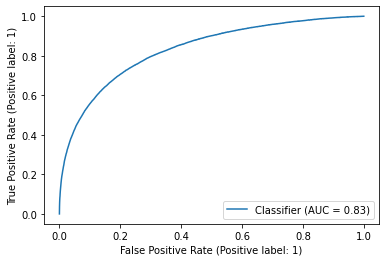

In [37]:
metrics.RocCurveDisplay.from_predictions(
  data_test, model.predict_proba(data_train)[:,1]
)

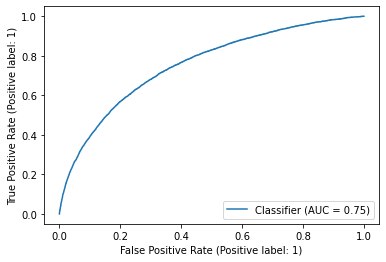

In [38]:
metrics.RocCurveDisplay.from_predictions(
  y_test1, pred1
)

In [41]:
? metrics.RocCurveDisplay.from_predictions

Signature:
 metrics.RocCurveDisplay.from_predictions(
    y_true,
    y_pred,
    *,
    sample_weight=None,
    drop_intermediate=True,
    pos_label=None,
    name=None,
    ax=None,
    **kwargs,
)
Docstring:
Plot ROC curve given the true and predicted values.

Read more in the :ref:`User Guide <visualizations>`.

.. versionadded:: 1.0

Parameters
----------
y_true : array-like of shape (n_samples,)
    True labels.

y_pred : array-like of shape (n_samples,)
    Target scores, can either be probability estimates of the positive
    class, confidence values, or non-thresholded measure of decisions
    (as returned by “decision_function” on some classifiers).

sample_weight : array-like of shape (n_samples,), default=None
    Sample weights.

drop_intermediate : bool, default=True
    Whether to drop some suboptimal thresholds which would not appear
    on a plotted ROC curve. This is useful in order to create lighter
    ROC curves.

pos_label : str or int, default=None
    The label

method 2

In [ ]:
from sklearn import tree
clf1=tree.DecisionTreeClassifier().fit(data_train,data_test)


In [ ]:
pred1=clf1.predict_proba(X_test1)[:,0]
metrics.roc_auc_score(y_test1, pred1)

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
clf2 = make_pipeline(StandardScaler(),SGDClassifier(loss='hinge',max_iter=1000, tol=1e-3))
clf2=clf2.fit(data_train,data_test)


In [ ]:
pred2=clf2.predict(X_test1)
metrics.roc_auc_score(y_test1, pred2)

In [ ]:
print('分类报告:\n',classification_report(y_test1,pred1))

In [ ]:
print('混淆矩阵为：\n',confusion_matrix(y_test1,pred1,labels=[0,1,2]))

In [ ]:
# ALTERNATIVE CV
import optuna.integration.lightgbm as lgb
dtrain = lgb.Dataset(data_train, label=data_test)

# 5折交叉验证
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

In [ ]:
?study.optimize